In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from  scipy.integrate import quad
import trimesh

In [2]:
file = uproot.open("./combined.root")
file.keys()

['MyAnalyzerFilter;1', 'MyAnalyzerFilter/Event;1']

In [3]:
T_eval_vars = [                     # variables involved with low level reconstruction and truth information
    "run",                          # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "mc_pdg",   
    "mc_mother",
    "mc_trackID",
    "mc_statusCode",
    "mc_energy",
    "mc_vx",
    "mc_vy",
    "mc_vz",
    "mc_time",
    "NumberDaughters",
    "pdg",
    "status",
    "Eng",
    "Mass",
    "Px",
    "Py",
    "Pz",
    "StartPointx",
    "StartPointy",
    "StartPointz",
    "EndPointx",
    "EndPointy",
    "EndPointz",
    "TrackId",
    "Mother"
]

vars = {}
vars.update(file["MyAnalyzerFilter/"]["Event"].arrays(T_eval_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
wc_df = pd.DataFrame(vars)

In [4]:
wc_df['N_pi0_genie'] = wc_df.apply(
    lambda row: sum(
        x == 111 and y == 1
        for x, y in zip(row['mc_pdg'], row['mc_statusCode'])
    ),
    axis=1
)

NC1pi0_mask = wc_df["N_pi0_genie"] == 1
NC2pi0_mask = wc_df["N_pi0_genie"] > 1

In [5]:
wc_df['nu_energy'] = wc_df['Eng'].apply(lambda row: row[0])
wc_df['nu_energy']

0        0.378351
1        0.178131
2        0.268741
3        0.188736
4        0.452499
           ...   
75016    0.783426
75017    0.476897
75018    0.270870
75019    0.312148
75020    0.172923
Name: nu_energy, Length: 75021, dtype: float32

In [6]:
def threshEqual(v1, v2, threshold=1e-8):
    return np.abs(v1-v2) <= threshold

thresh = 1e-8
genieToG4Pi0 = {}
g4ToGeniePi0 = {}
for i, row in wc_df.iterrows():
    for k, pdg in enumerate(row.pdg):
        if pdg == 111:
            for j, mc_pdg in enumerate(row.mc_pdg):
                if mc_pdg == 111 and row.mc_statusCode[j] == 1:
                    if (threshEqual(row.mc_energy[j], row.Eng[k], thresh) and
                        threshEqual(row.mc_vx[j], row.StartPointx[k], thresh) and
                        threshEqual(row.mc_vy[j], row.StartPointy[k], thresh) and
                        threshEqual(row.mc_vz[j], row.StartPointz[k], thresh)):
                        genieToG4Pi0[(i, j)] = (i, k)
                        g4ToGeniePi0[(i, k)] = (i, j)
print(len(genieToG4Pi0))
print(len(g4ToGeniePi0))

80523
80523


In [7]:
wc_df['N_ch_pion_genie'] = wc_df.apply(
    lambda row: sum(
        (x == 211 or x == -211) and y == 1
        for x, y in zip(row['mc_pdg'], row['mc_statusCode'])
    ),
    axis=1
)
wc_df['N_ch_pion_genie']

0        1
1        0
2        0
3        0
4        0
        ..
75016    0
75017    0
75018    1
75019    2
75020    0
Name: N_ch_pion_genie, Length: 75021, dtype: int64

In [8]:
wc_df['is_CC'] = wc_df.apply(
    lambda row: any(x in [13, -13, 11, -11] for x in row['mc_pdg']),
    axis=1
)
CC_mask = wc_df['is_CC']

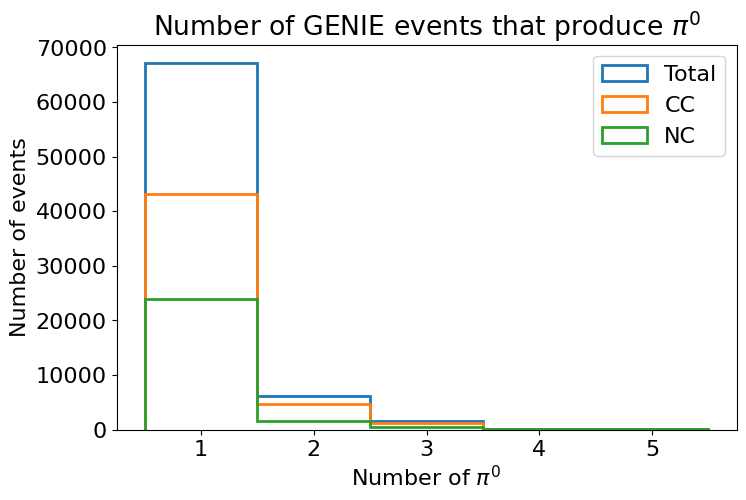

In [9]:
plt.rcParams.update({'font.size': 16})
lw=2

plt.figure(figsize=(8, 5))
plt.hist(wc_df["N_pi0_genie"], bins=5, range=(0.5,5.5), histtype="step", lw=lw, label='Total')
plt.hist(wc_df["N_pi0_genie"][CC_mask], bins=5, range=(0.5,5.5), histtype="step", lw=lw, label='CC')
plt.hist(wc_df["N_pi0_genie"][~CC_mask], bins=5, range=(0.5,5.5), histtype="step", lw=lw, label='NC')
plt.legend()
plt.xlabel(r"Number of $\pi^0$")
plt.ylabel("Number of events")
plt.title(r"Number of GENIE events that produce $\pi^0$")
plt.show()

In [10]:
g4Pi0ToGamma = {}
for i, row in wc_df.iterrows():
    for j, pdg in enumerate(row.pdg):
        if pdg == 22:
            k = int(np.where(row.TrackId == row.Mother[j])[0][0])
            piTup = (i, k)
            gTup = (i, j)
            if piTup in g4Pi0ToGamma:
                g4Pi0ToGamma[piTup] = np.append(g4Pi0ToGamma[piTup], gTup)
            else:
                g4Pi0ToGamma[piTup] = np.array([gTup], dtype=object)

In [11]:
# distance to tpc edge
tpcMinX = -200
tpcMaxX = 200
tpcMinY = -200
tpcMaxY = 200
tpcMinZ = 0
tpcMaxZ = 500

def inTPC(x, y, z):
    return (
        x >= tpcMinX and x <= tpcMaxX and
        y >= tpcMinY and y <= tpcMaxY and
        z >= tpcMinZ and z <= tpcMaxZ
    )

def distToEdge(x, y, z):
    return min(abs(x-tpcMinX), abs(x-tpcMaxX), abs(y-tpcMinY), abs(y-tpcMaxY), abs(z-tpcMinZ), abs(z-tpcMaxZ))

def signedDistToEdge(x, y, z):
    if inTPC(x, y, z):
        return distToEdge(x, y, z)
    arr = np.array([x-tpcMinX, x-tpcMaxX, y-tpcMinY, y-tpcMaxY, z-tpcMinZ, z-tpcMaxZ])
    return arr[np.argmin(np.abs(arr))]

In [12]:
wc_df['in_TPC_g4'] = wc_df.apply(
    lambda row: [inTPC(row['StartPointx'][x], row['StartPointy'][x], row['StartPointz'][x]) for x in range(len(row['pdg']))],
    axis=1
)
wc_df['in_TPC_g4']

0                                       [True, True, True]
1        [False, False, False, False, False, False, Fal...
2                                       [True, True, True]
3                                       [True, True, True]
4                  [True, True, True, False, False, False]
                               ...                        
75016                                [False, False, False]
75017                                [False, False, False]
75018           [False, False, False, False, False, False]
75019    [False, False, False, False, False, False, Fal...
75020                                   [True, True, True]
Name: in_TPC_g4, Length: 75021, dtype: object

In [13]:
wc_df['dist_to_edge_g4'] = wc_df.apply(
    lambda row: [distToEdge(row['StartPointx'][x], row['StartPointy'][x], row['StartPointz'][x]) for x in range(len(row['pdg']))],
    axis=1
)
wc_df['signed_dist_to_edge_g4'] = wc_df.apply(
    lambda row: [signedDistToEdge(row['StartPointx'][x], row['StartPointy'][x], row['StartPointz'][x]) for x in range(len(row['pdg']))],
    axis=1
)

In [14]:
wc_df['has_nonPrimary'] = wc_df.apply(
    lambda row: any(
        pdg == 111 and (row.name, idx) not in g4ToGeniePi0
        for idx, pdg in enumerate(row['pdg'])
    ),
    axis=1
)
print((wc_df['has_nonPrimary'] == True).sum())

52792


In [15]:
npX1 = np.array([])
npY1 = np.array([])
npX2 = np.array([])
npY2 = np.array([])
for i, row in wc_df.iterrows():
    if not row.has_nonPrimary:
        continue
    for j, pdg in enumerate(row.pdg):
        if pdg == 111 and (i, j) not in g4ToGeniePi0:
            if row.StartPointy[j] > 30000:
                print(i)
            if str(row.Mother[j])[0] == '1':
                npX1 = np.append(npX1, row.StartPointx[j])
                npY1 = np.append(npY1, row.StartPointy[j])
            else:
                assert str(row.Mother[j])[0] == '2'
                npX2 = np.append(npX2, row.StartPointx[j])
                npY2 = np.append(npY2, row.StartPointy[j])

70065


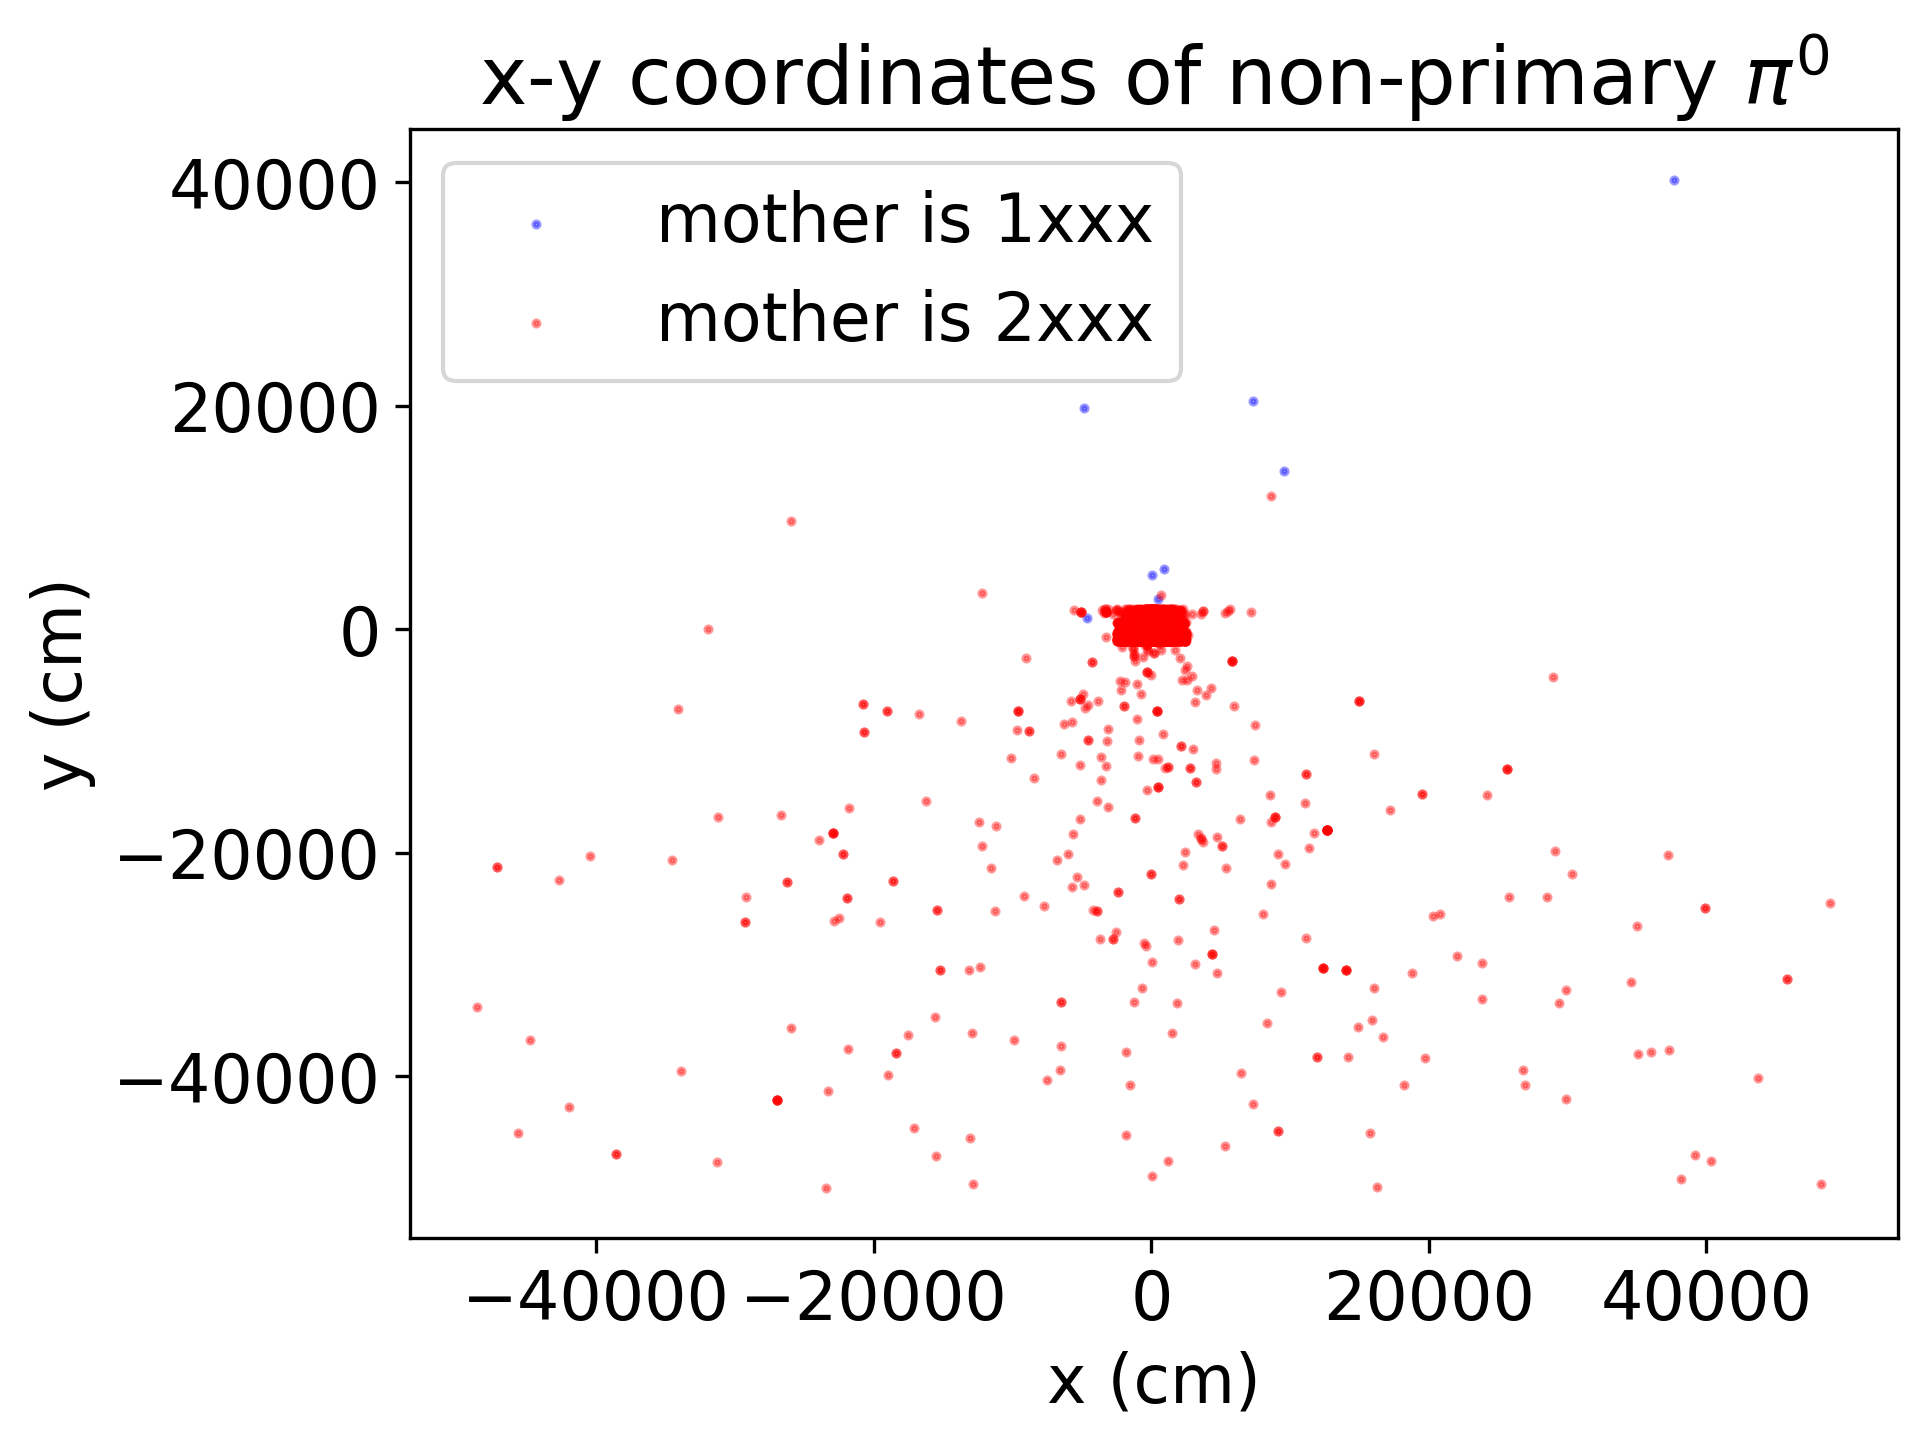

In [16]:
plt.figure(dpi=300)
plt.scatter(npX1, npY1, s=2, alpha=0.4, color='b', label='mother is 1xxx')
plt.scatter(npX2, npY2, s=2, alpha=0.4, color='r', label='mother is 2xxx')
plt.title(r'x-y coordinates of non-primary $\pi^0$')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.show()

In [17]:
'''def pdg_name(pdg_id):
    pdg_dict = {
        11: "e⁻", -11: "e⁺",
        13: "μ⁻", -13: "μ⁺",
        15: "τ⁻", -15: "τ⁺",
        12: "νₑ", -12: "ν̄ₑ",
        14: "ν_μ", -14: "ν̄_μ",
        16: "ν_τ", -16: "ν̄_τ",
        22: "γ",
        111: "π⁰", 211: "π⁺", -211: "π⁻",
        2212: "p", -2212: "p̄",
        2112: "n", -2112: "n̄",
        130: "K⁰_L", 310: "K⁰_S",
        321: "K⁺", -321: "K⁻",
        2224: "Δ⁺⁺", 2214: "Δ⁺", 2114: "Δ⁰", 1114: "Δ⁻",
    }
    return pdg_dict.get(pdg_id, str(pdg_id))

def get_particle_color(pdg_id):
    if pdg_id in [11, -11, 12, -12]:
        return "green"
    elif pdg_id in [22, 111]:
        return "red"
    elif pdg_id in [13, -13, 14, -14]:
        return "lightblue"
    elif pdg_id in [2212]:
        return "orange"
    elif pdg_id in [211,-211]:
        return "cyan"
    else:
        return "gray"

def plot_family_tree(row, event_id=None):
    G = nx.DiGraph() 
    track_ids = row['mc_trackID']
    mother_ids = row['mc_mother']
    pdgs = row['mc_pdg']
    energies = row['mc_energy']
    status = row['mc_statusCode']
    
    labels = {}
    node_colors = []
    for i, tid in enumerate(track_ids):
        pdg = pdgs[i]
        energy = energies[i]
        label = f"{tid} : {pdg_name(pdg)}\nE: {energy:.2f} \nSt: {status[i]}"
        labels[tid] = label
        G.add_node(tid)
        node_colors.append(get_particle_color(pdg))

    
    # Add edges from mother to daughter p, should work?
    for i, (tid, mother_tid) in enumerate(zip(track_ids, mother_ids)):
        if mother_tid in track_ids:
            G.add_edge(mother_tid, tid)
    
    
    plt.figure(figsize=(10, 6))
    #pos = nx.spring_layout(G, k=0.5, iterations=100)
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=True, node_size=5000,node_color=node_colors)
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
    plt.title(f"GENIE Particle Family Tree" + (f" — Event {event_id}" if event_id is not None else ""))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#example event
plot_family_tree(wc_df.iloc[2], event_id=2)'''

'def pdg_name(pdg_id):\n    pdg_dict = {\n        11: "e⁻", -11: "e⁺",\n        13: "μ⁻", -13: "μ⁺",\n        15: "τ⁻", -15: "τ⁺",\n        12: "νₑ", -12: "ν̄ₑ",\n        14: "ν_μ", -14: "ν̄_μ",\n        16: "ν_τ", -16: "ν̄_τ",\n        22: "γ",\n        111: "π⁰", 211: "π⁺", -211: "π⁻",\n        2212: "p", -2212: "p̄",\n        2112: "n", -2112: "n̄",\n        130: "K⁰_L", 310: "K⁰_S",\n        321: "K⁺", -321: "K⁻",\n        2224: "Δ⁺⁺", 2214: "Δ⁺", 2114: "Δ⁰", 1114: "Δ⁻",\n    }\n    return pdg_dict.get(pdg_id, str(pdg_id))\n\ndef get_particle_color(pdg_id):\n    if pdg_id in [11, -11, 12, -12]:\n        return "green"\n    elif pdg_id in [22, 111]:\n        return "red"\n    elif pdg_id in [13, -13, 14, -14]:\n        return "lightblue"\n    elif pdg_id in [2212]:\n        return "orange"\n    elif pdg_id in [211,-211]:\n        return "cyan"\n    else:\n        return "gray"\n\ndef plot_family_tree(row, event_id=None):\n    G = nx.DiGraph() \n    track_ids = row[\'mc_trackID\']\n 

In [18]:
'''def plot_combined_tree(row, event_id=None):
    G = nx.DiGraph()
    labels = {}
    node_colors = {}
    
    used_g4_track_ids = set()

    mc_tid = row["mc_trackID"]
    mc_mid = row["mc_mother"]
    mc_pdg = row["mc_pdg"]
    mc_energy = row["mc_energy"]
    mc_status = row["mc_statusCode"]

    genie_pi0s = []

    for i, tid in enumerate(mc_tid):
        pdg = mc_pdg[i]
        energy = mc_energy[i]
        #label = f"{tid}\n{pdg_name(pdg)}\nE: {energy:.2f}"
        label = f"{tid} : {pdg_name(pdg)}\nE: {energy:.2f} \nSt: {mc_status[i]}"
        labels[tid] = label
        node_colors[tid] = get_particle_color(pdg)
        G.add_node(tid)
        if mc_mid[i] in mc_tid:
            G.add_edge(mc_mid[i], tid)

        if pdg == 111 and mc_status[i] == 1:
            genie_pi0s.append((tid, energy))

    g4_tid = row["TrackId"]
    g4_mid = row["Mother"]
    g4_pdg = row["pdg"]
    g4_energy = row["Eng"]

    #match genie/geant4 a bit
    matched_g4 = set()
    pi0_matches = []

    for i, pdg in enumerate(g4_pdg):
        if pdg != 111:
            continue
        for g_tid, g_energy in genie_pi0s:
            if threshEqual(g4_energy[i], g_energy):
                pi0_matches.append((g_tid, g4_tid[i]))
                matched_g4.add(g4_tid[i])
                break

    for g_tid_genie, g_tid_g4 in pi0_matches:
        g4_tid_map = {}  # mapping G4 trackID to pdg, energy, mother
        for i, tid in enumerate(g4_tid):
            if g4_pdg[i] in [11, -11, 22, 111]:  # Only e±, γ, π⁰
                g4_tid_map[tid] = {
                    "pdg": g4_pdg[i],
                    "energy": g4_energy[i],
                    "mother": g4_mid[i]
                }

        for tid, info in g4_tid_map.items():
            pdg = info["pdg"]
            energy = info["energy"]
            mother = info["mother"]
            label = f"{tid}\n{pdg_name(pdg)}\nE: {energy:.2f}"
            labels[tid] = label
            node_colors[tid] = get_particle_color(pdg)
            G.add_node(tid)
            used_g4_track_ids.add(tid)
            if mother in g4_tid_map:
                G.add_edge(mother, tid)
            elif tid == g_tid_g4:
                G.add_edge(g_tid_genie, tid)

        #corsika nad reinteractions add as well
    for i, tid in enumerate(g4_tid):
        if tid in used_g4_track_ids:
            continue
        pdg = g4_pdg[i]
        if pdg not in [11, -11, 22, 111]:
            continue
        energy = g4_energy[i]
        label = f"{tid}\n{pdg_name(pdg)}\nE: {energy:.2f}"
        labels[tid] = label
        node_colors[tid] = get_particle_color(pdg)
        G.add_node(tid)
        if g4_mid[i] in g4_tid:
            G.add_edge(g4_mid[i], tid)

    pos = graphviz_layout(G, prog='dot')

    genie_nodes = [n for n in G.nodes if n in mc_tid]
    g4_nodes = [n for n in G.nodes if n not in mc_tid]

    plt.figure(figsize=(14, 10))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=genie_nodes,
        node_color=[node_colors[n] for n in genie_nodes],  # match genie_nodes
        node_size=6500,
        edgecolors="black",
        node_shape='o'
    )
    
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=g4_nodes,
        node_color=[node_colors[n] for n in g4_nodes],    # match g4_nodes
        node_size=6500,
        edgecolors="black",
        node_shape='s'
    )


    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_labels(G, pos, labels, font_size=14)
    
    plt.title(f"Combined GENIE + G4 Tree — Event {event_id}" if event_id is not None else "Combined GENIE + G4 Tree", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_combined_tree(wc_df.iloc[70065], event_id=70065)'''

'def plot_combined_tree(row, event_id=None):\n    G = nx.DiGraph()\n    labels = {}\n    node_colors = {}\n    \n    used_g4_track_ids = set()\n\n    mc_tid = row["mc_trackID"]\n    mc_mid = row["mc_mother"]\n    mc_pdg = row["mc_pdg"]\n    mc_energy = row["mc_energy"]\n    mc_status = row["mc_statusCode"]\n\n    genie_pi0s = []\n\n    for i, tid in enumerate(mc_tid):\n        pdg = mc_pdg[i]\n        energy = mc_energy[i]\n        #label = f"{tid}\n{pdg_name(pdg)}\nE: {energy:.2f}"\n        label = f"{tid} : {pdg_name(pdg)}\nE: {energy:.2f} \nSt: {mc_status[i]}"\n        labels[tid] = label\n        node_colors[tid] = get_particle_color(pdg)\n        G.add_node(tid)\n        if mc_mid[i] in mc_tid:\n            G.add_edge(mc_mid[i], tid)\n\n        if pdg == 111 and mc_status[i] == 1:\n            genie_pi0s.append((tid, energy))\n\n    g4_tid = row["TrackId"]\n    g4_mid = row["Mother"]\n    g4_pdg = row["pdg"]\n    g4_energy = row["Eng"]\n\n    #match genie/geant4 a bit\n    matched

In [19]:
wc_df['N_showers'] = wc_df.apply(
    lambda row: sum((x in [11, -11] and inTPC(row['StartPointx'][i], row['StartPointy'][i], row['StartPointz'][i]))
                    or (x == 22 and inTPC(row['EndPointx'][i], row['EndPointy'][i], row['EndPointz'][i]))
                    for i, x in enumerate(row['pdg'])),
                    axis=1
)
single_shower = wc_df['N_showers'] == 1
sum(wc_df['N_showers'] == 1)

6933

In [20]:
wc_df['shower_origin'] = wc_df.apply(
    lambda row: [1 if ((x in [11, -11] and inTPC(row['StartPointx'][i], row['StartPointy'][i], row['StartPointz'][i]))
                      or (x == 22 and inTPC(row['EndPointx'][i], row['EndPointy'][i], row['EndPointz'][i]))) 
                 else 0 for i, x in enumerate(row['pdg'])],
                axis = 1
)
wc_df['shower_pi0_dex'] = wc_df.apply(
    lambda row: list(dict.fromkeys(
                     int(np.where(row['TrackId'] == row['Mother'][i])[0][0])
                     for i, origin in enumerate(row['shower_origin']) if origin == 1)),
    axis=1
)

In [21]:
# Plot settings
colorTot = 'C0'; colorP = 'C1'; colorNP = 'C2'
ylimit = (0,)
xlimit=(0,)
erAlpha = 0.3

2571


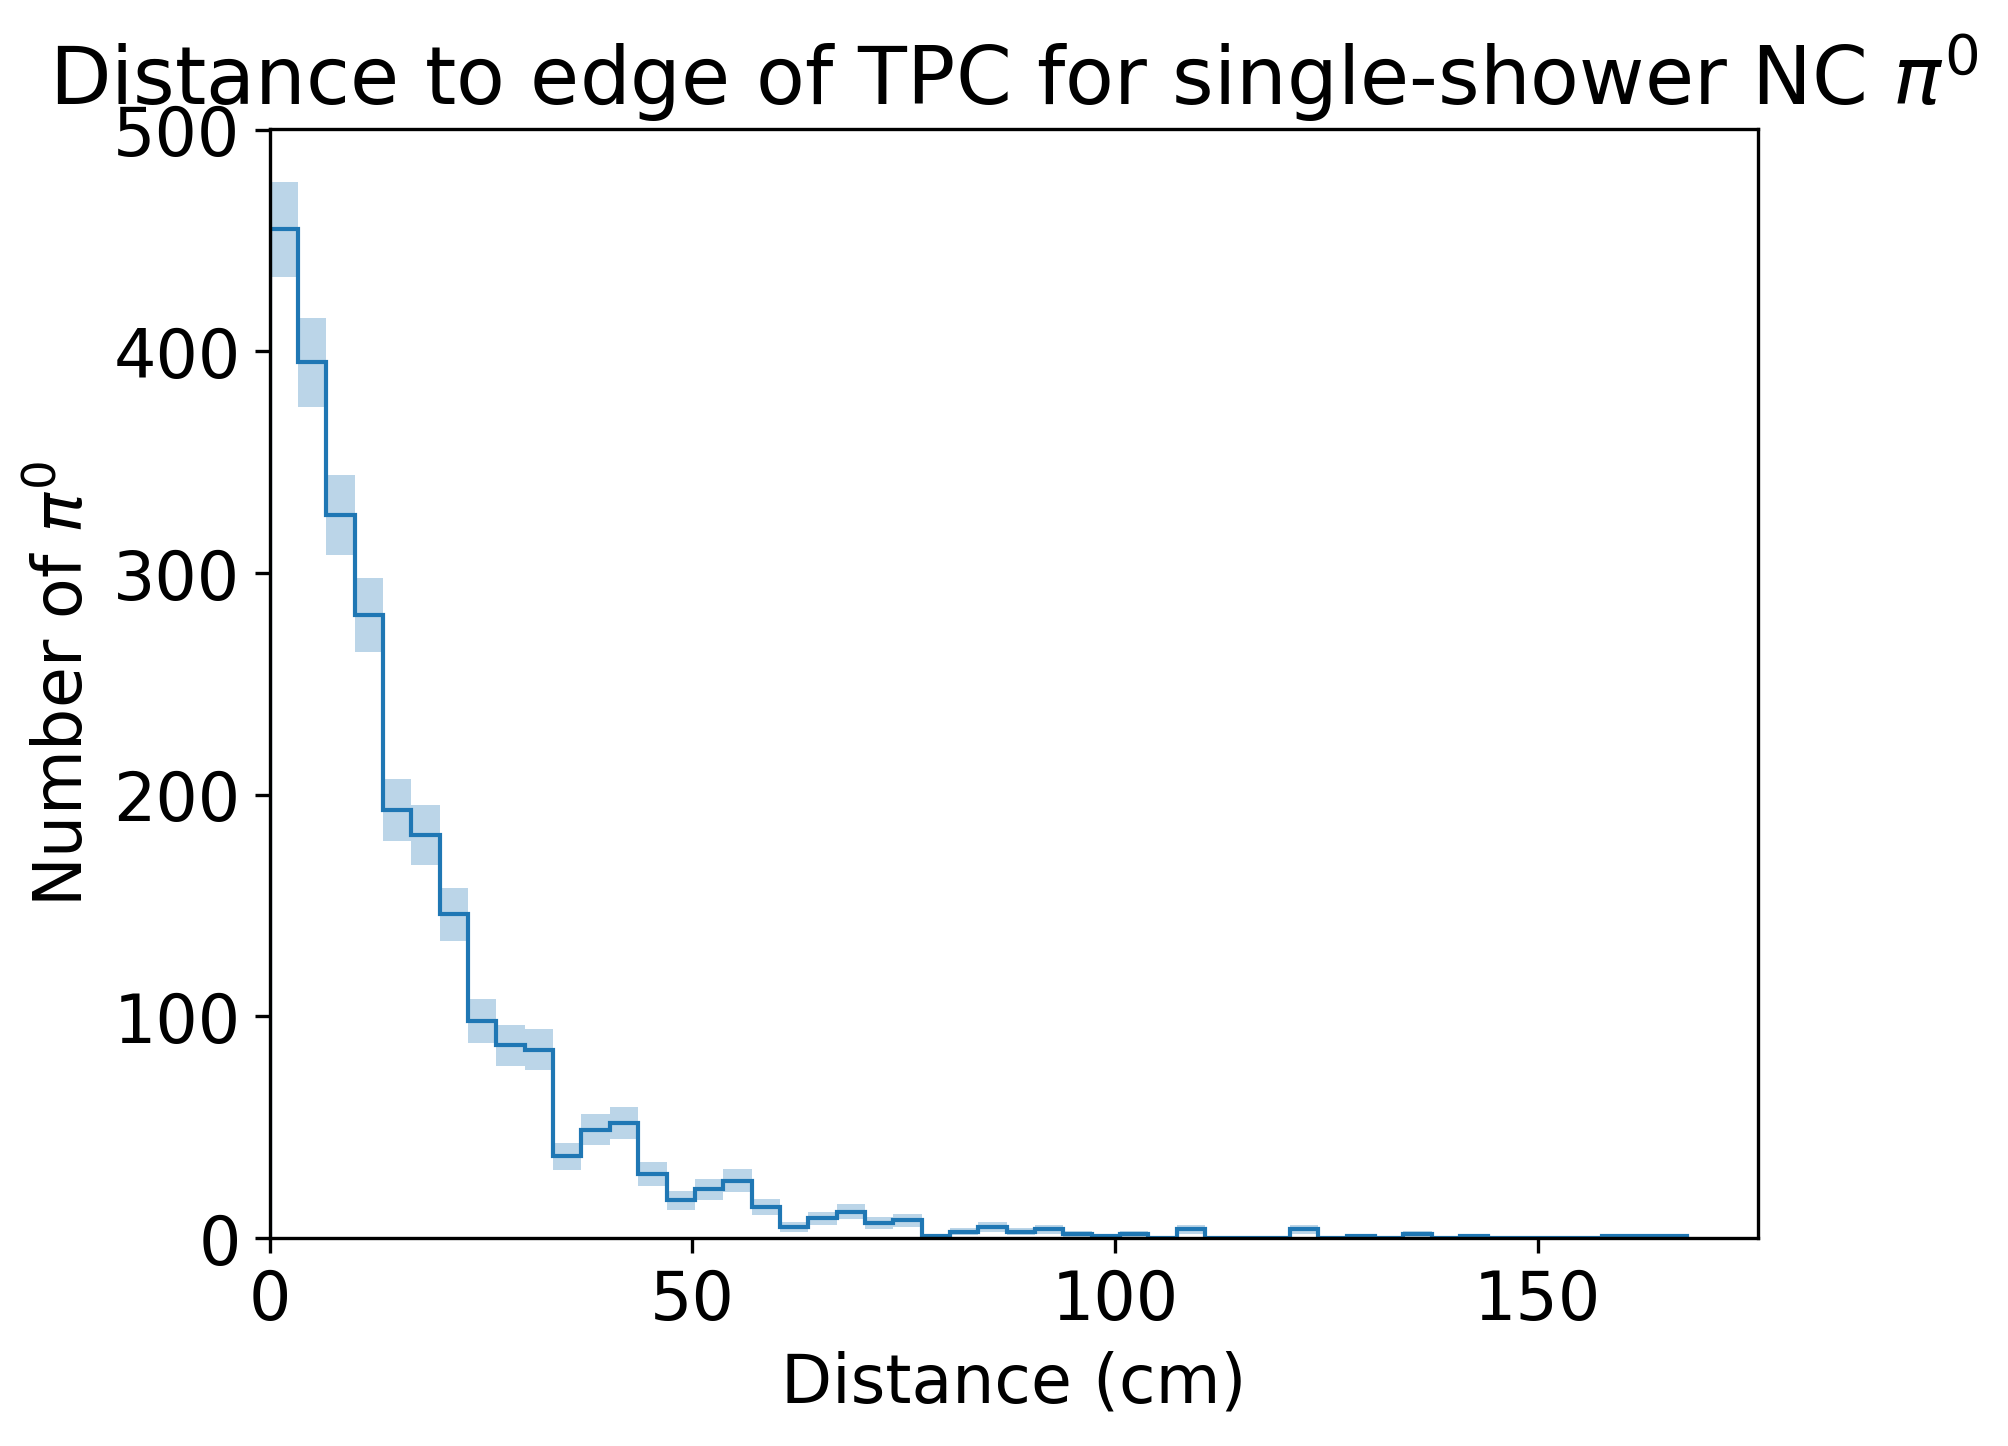

In [22]:
distances = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    distances = np.append(distances, row['dist_to_edge_g4'][row['shower_pi0_dex'][0]])
print(len(distances))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(distances, bins=50, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot)
plt.title('Distance to edge of TPC for single-shower NC $\pi^0$')
plt.xlabel('Distance (cm)')
plt.ylabel('Number of $\pi^0$')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

In [23]:
len(wc_df[~CC_mask & single_shower])

2571

In [24]:
wc_df['shower_position'] = wc_df.apply(
    lambda row: [(row['StartPointx'][i], row['StartPointy'][i], row['StartPointz'][i])
                 if (row['pdg'][i] in [11, -11]) and show == 1
                 else (row['EndPointx'][i], row['EndPointy'][i], row['EndPointz'][i])
                 for i, show in enumerate(row['shower_origin'])
                 if (row['pdg'][i] in [11, -11, 22]) and show == 1],
    axis=1
)

In [25]:
def offAxAngle(x, y, z, exact, backface):
    if exact: 
        return np.arctan2(((x+74)**2 + y**2)**0.5, z+11000)*180/np.pi
    if backface:
        return np.arctan2(((x+74)**2 + y**2)**0.5, 11500)*180/np.pi
    return np.arctan2(((x+74)**2 + y**2)**0.5, 11000)*180/np.pi

wc_df['shower_angle'] = wc_df.apply(
    lambda row: offAxAngle(row['shower_position'][0][0], row['shower_position'][0][1], row['shower_position'][0][2], False, False) if row['N_showers'] == 1 else None,
    axis = 1
)

In [26]:
nbins = np.arange(0, 4.1, .2)
nbinsTPC = np.arange(0, 1.61, .2)

In [27]:
norm_areas = np.array([])
for i in range(len(nbinsTPC)-1):
    radius = 110 * np.tan(nbinsTPC[i+1] * np.pi / 180)
    area = np.pi * radius**2
    if i > 0:
        if radius > 1.26:
            area -= quad(lambda x: 2*np.sqrt(radius**2 - x**2), 1.26, radius)[0]
        if radius > 2:
            area -= quad(lambda y: 4*np.sqrt(radius**2 - y**2), 2, radius)[0]
            area += quad(lambda x1: 2*(np.sqrt(radius**2 - x1**2) - 2), 1.26, np.sqrt(radius**2 - 4))[0]
        if radius > 2.74:
            area -= quad(lambda z: 2*np.sqrt(radius**2 - z**2), 2.74, radius)[0]
            area += quad(lambda x2: 2*(np.sqrt(radius**2 - x2**2) - 2), 2.74, np.sqrt(radius**2 - 4))[0]
        area -= np.sum(norm_areas[0:i])
    norm_areas = np.append(norm_areas, np.abs(area))
norm_areas

array([0.46318395, 1.38959699, 2.31614549, 2.91337013, 3.17304591,
       2.65379912, 1.78709595, 1.30376247])

In [28]:
norm_areas_back = np.array([])
for i in range(len(nbinsTPC)-1):
    radius = 115 * np.tan(nbinsTPC[i+1] * np.pi / 180)
    area = np.pi * radius**2
    if i > 0:
        if radius > 1.26:
            area -= quad(lambda x: 2*np.sqrt(radius**2 - x**2), 1.26, radius)[0]
        if radius > 2:
            area -= quad(lambda y: 4*np.sqrt(radius**2 - y**2), 2, radius)[0]
            area += quad(lambda x1: 2*(np.sqrt(radius**2 - x1**2) - 2), 1.26, np.sqrt(radius**2 - 4))[0]
        if radius > 2.74:
            area -= quad(lambda z: 2*np.sqrt(radius**2 - z**2), 2.74, radius)[0]
            area += quad(lambda x2: 2*(np.sqrt(radius**2 - x2**2) - 2), 2.74, np.sqrt(radius**2 - 4))[0]
        area -= np.sum(norm_areas_back[0:i])
    norm_areas_back = np.append(norm_areas_back, np.abs(area))
norm_areas_back

array([5.06248568e-01, 1.51879505e+00, 2.53148960e+00, 3.07453663e+00,
       3.73659467e+00, 2.04194745e+00, 2.59038803e+00, 7.10542736e-15])

In [57]:
tpcBox = trimesh.creation.box(extents=[4, 4, 5])
tpcBox.apply_translation([0, 0, 2.5])
norm_vols = np.array([])
for i in range(len(nbinsTPC)-1):
    radius = 115 * np.tan(nbinsTPC[i+1] * np.pi / 180)
    cone = trimesh.creation.cone(radius=radius, height=115)
    vol = cone.volume - cone.difference(tpcBox).volume
    if i > 0:
        vol -= np.sum(norm_vols[0:i])
    norm_vols = np.append(norm_vols, vol)
norm_vols

array([ 2.40724613,  7.22197472, 12.03740189, 16.85401715, 21.671929  ,
       14.81727631,  4.82415596,  0.16597083])

In [30]:
wc_df['shower_angle_back'] = wc_df.apply(
    lambda row: offAxAngle(row['shower_position'][0][0], row['shower_position'][0][1], row['shower_position'][0][2], False, True) if row['N_showers'] == 1 else None,
    axis = 1
)
wc_df['shower_angle_exact'] = wc_df.apply(
    lambda row: offAxAngle(row['shower_position'][0][0], row['shower_position'][0][1], row['shower_position'][0][2], True, False) if row['N_showers'] == 1 else None,
    axis = 1
)

2571


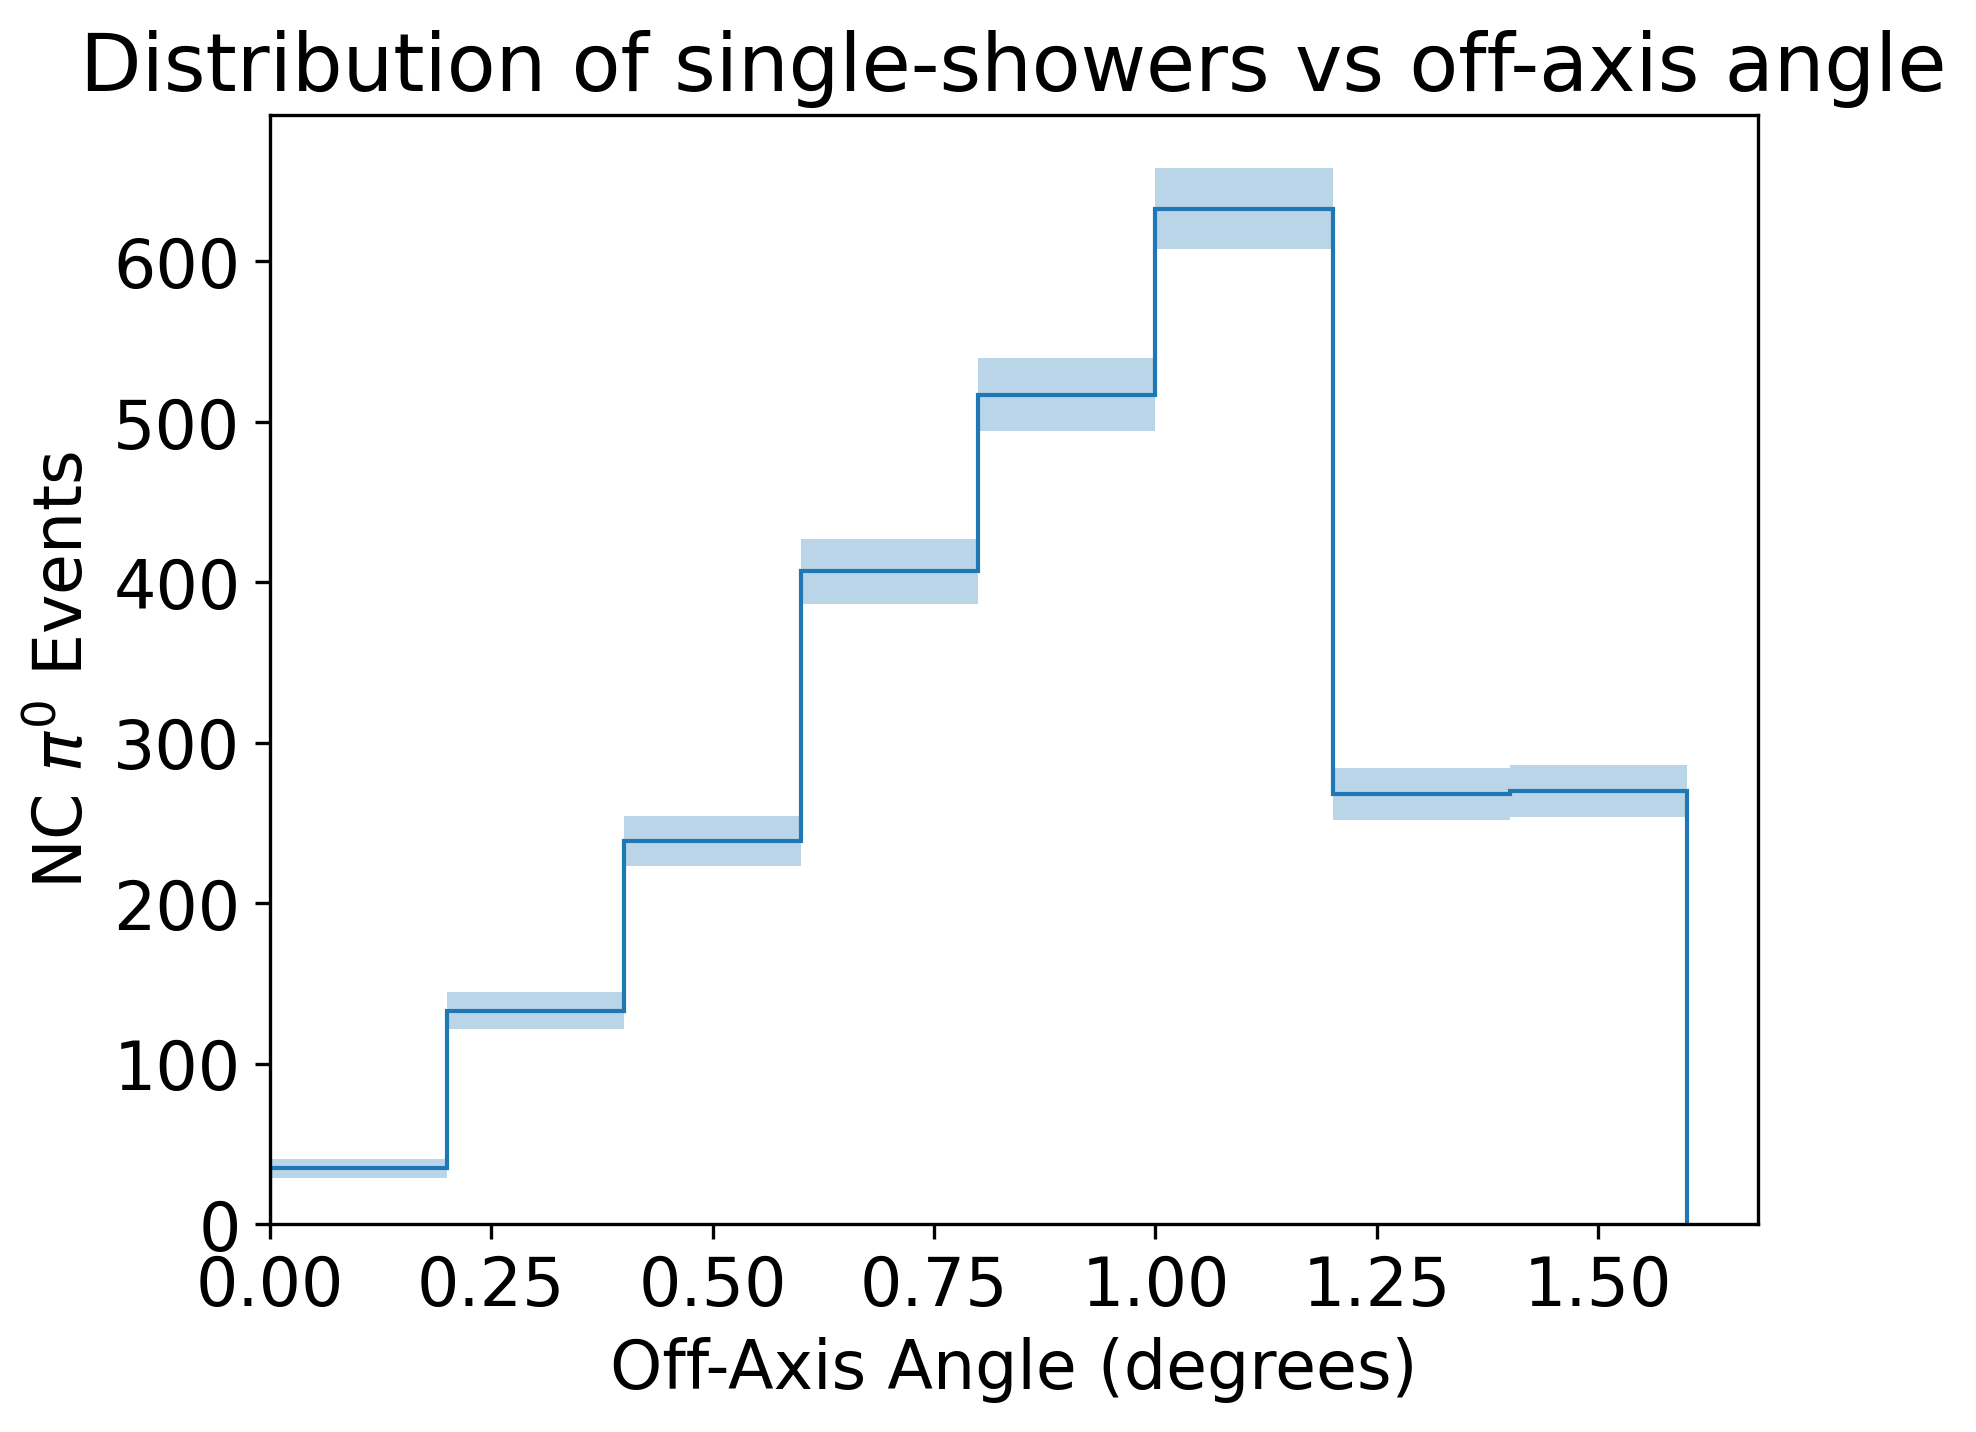

In [31]:
angles = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    angles = np.append(angles, row['shower_angle'])
print(len(angles))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles, bins=nbinsTPC, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot)
plt.title(r'Distribution of single-showers vs off-axis angle')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

2571


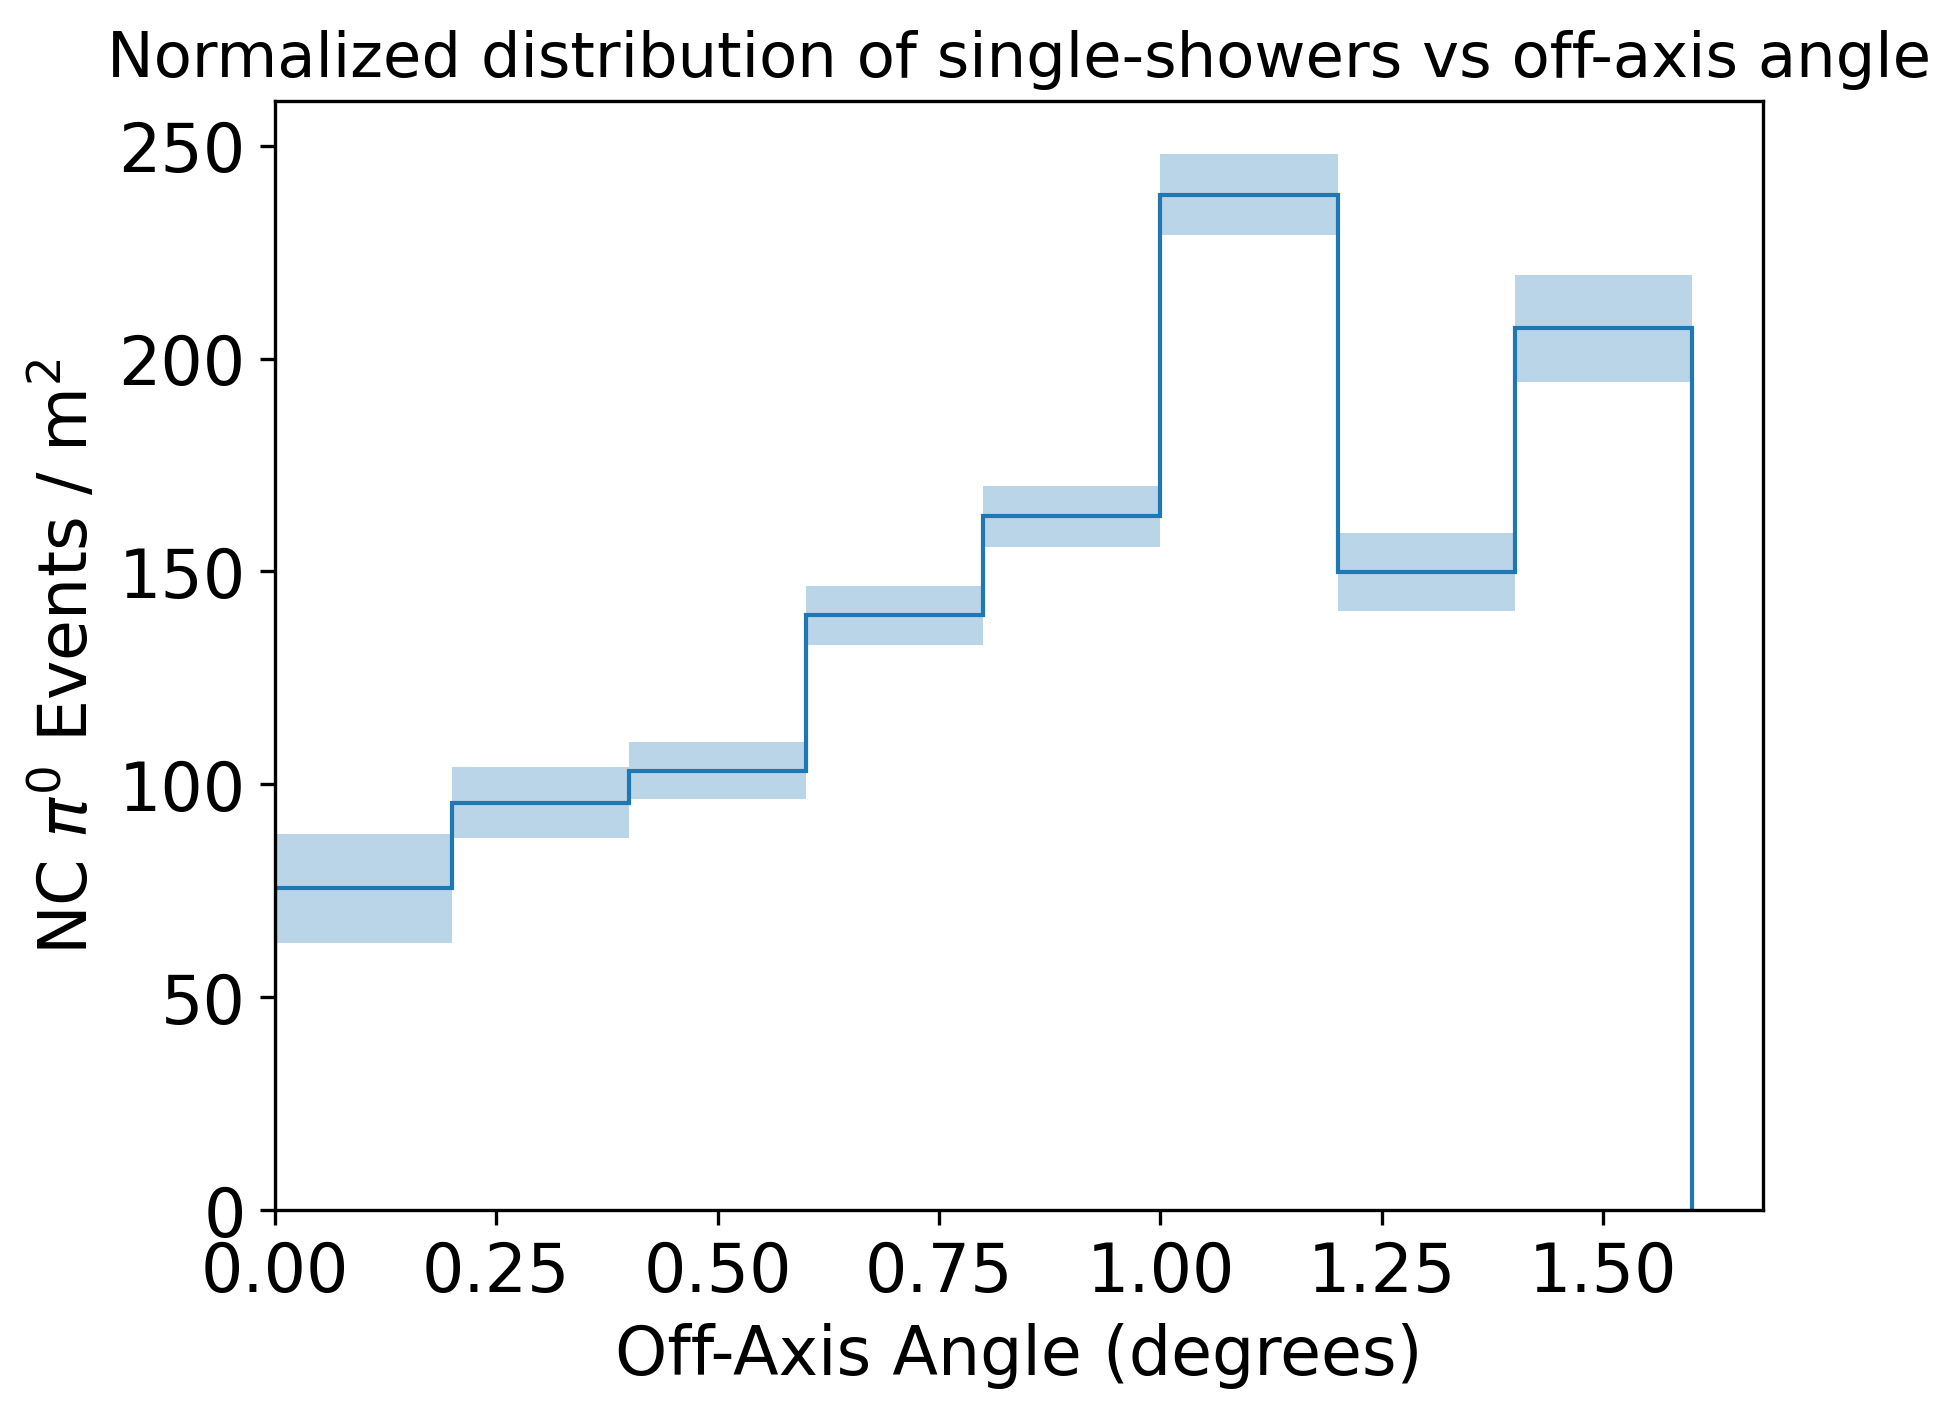

In [32]:
angles_norm = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    angles_norm = np.append(angles_norm, row['shower_angle'])
print(len(angles_norm))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles_norm, bins=nbinsTPC, histtype='step')
wide = np.diff(bins)
norm_counts = counts / norm_areas
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / norm_areas
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorTot)
plt.title(r'Normalized distribution of single-showers vs off-axis angle', fontsize = 15)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events / m$^2$')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

2571


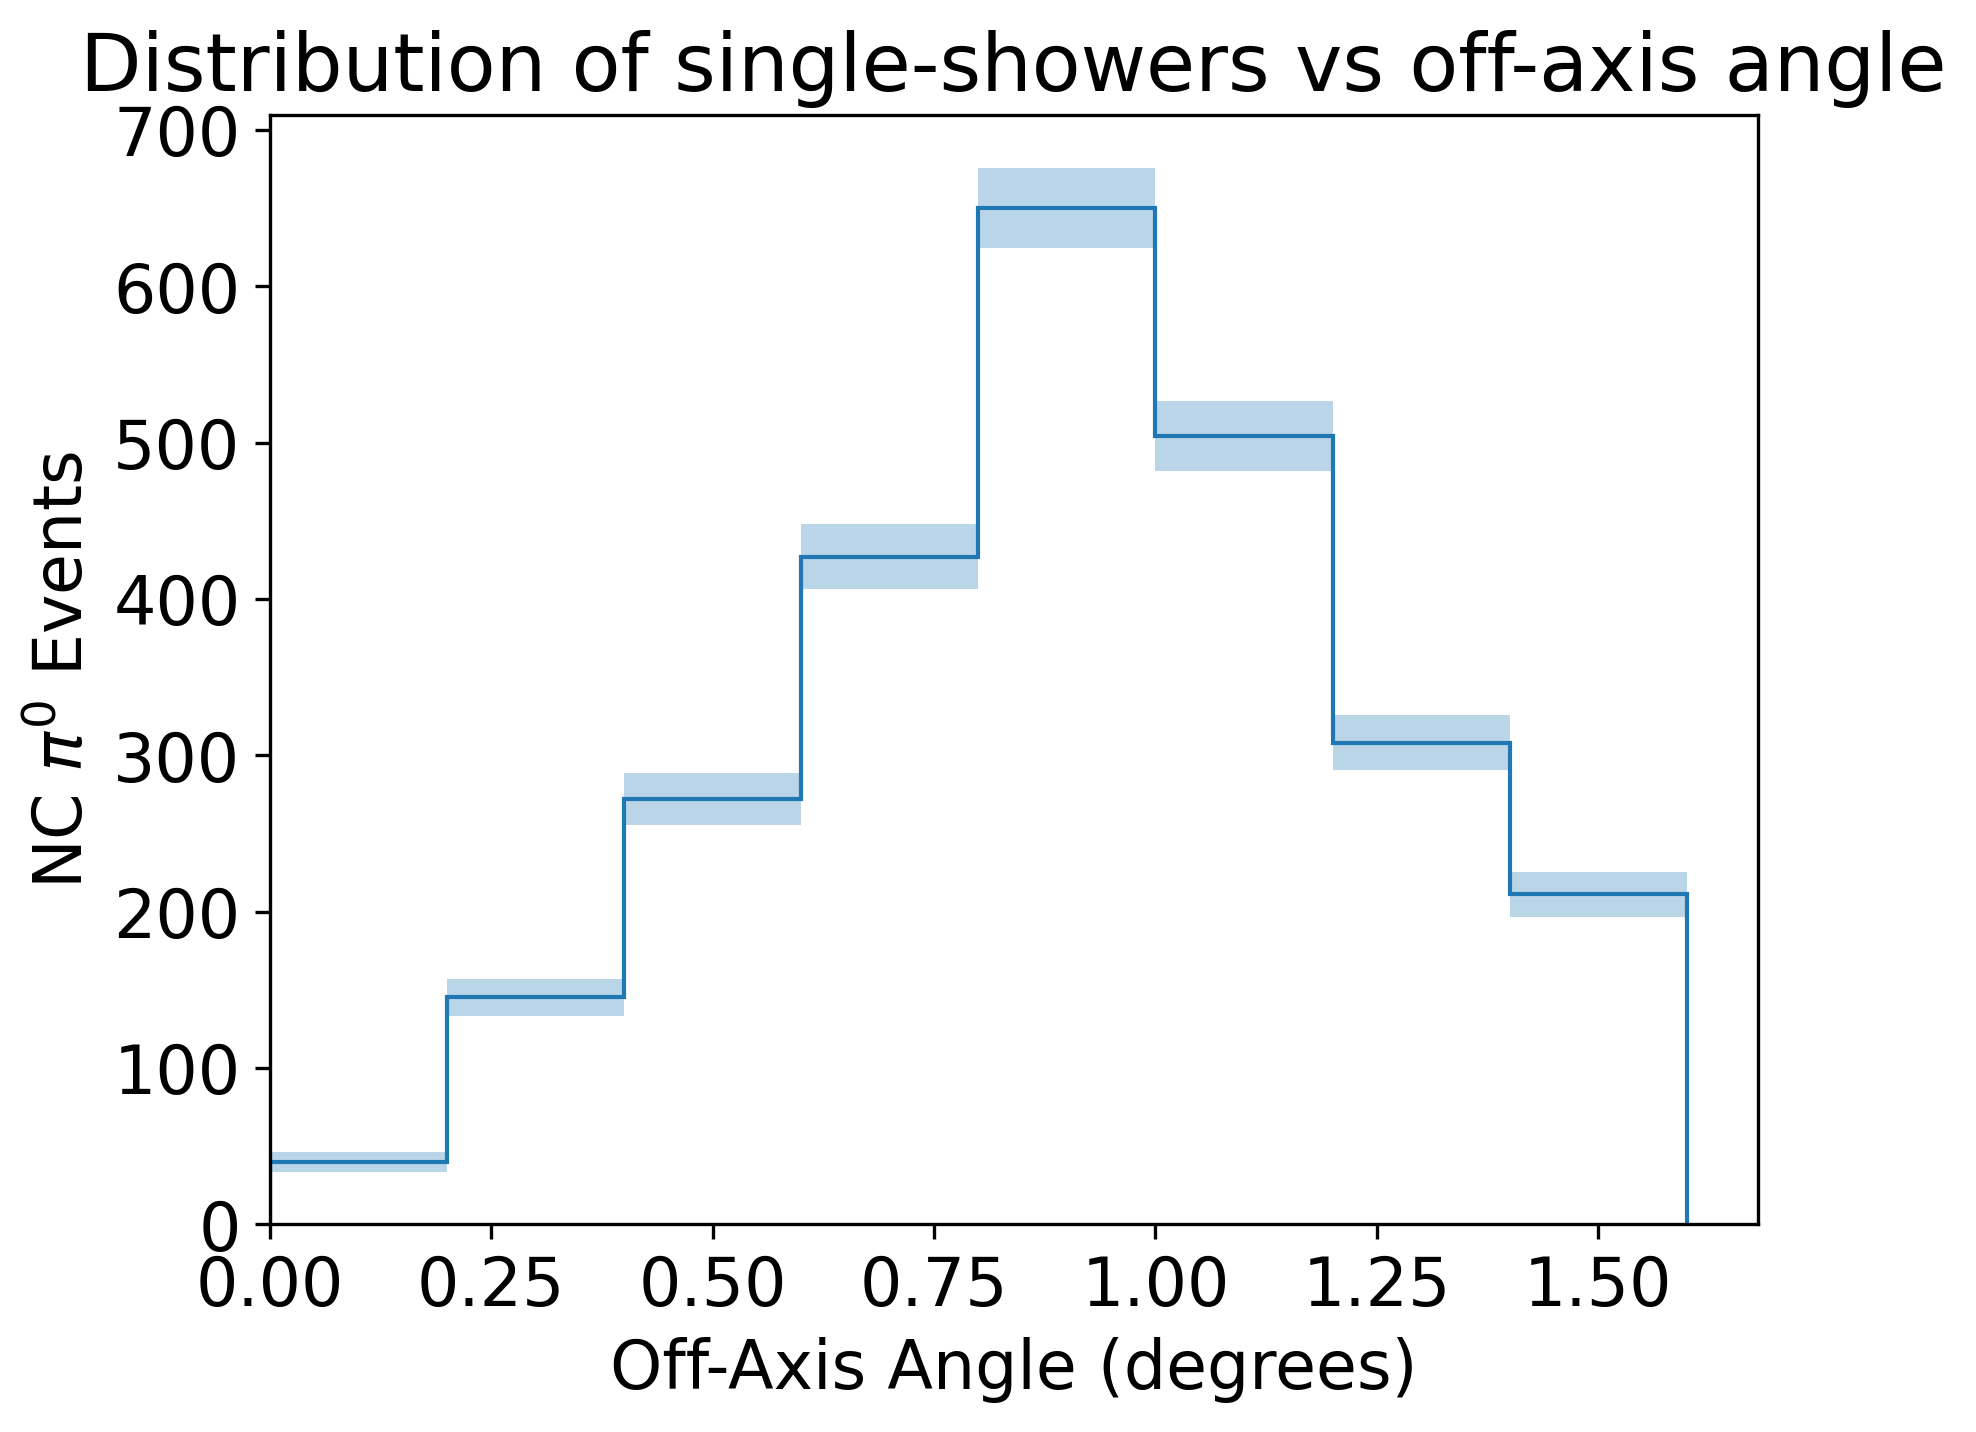

In [59]:
angles_back = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    angles_back = np.append(angles_back, row['shower_angle_back'])
print(len(angles_back))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles_back, bins=nbinsTPC, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot)
plt.title(r'Distribution of single-showers vs off-axis angle')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

2571


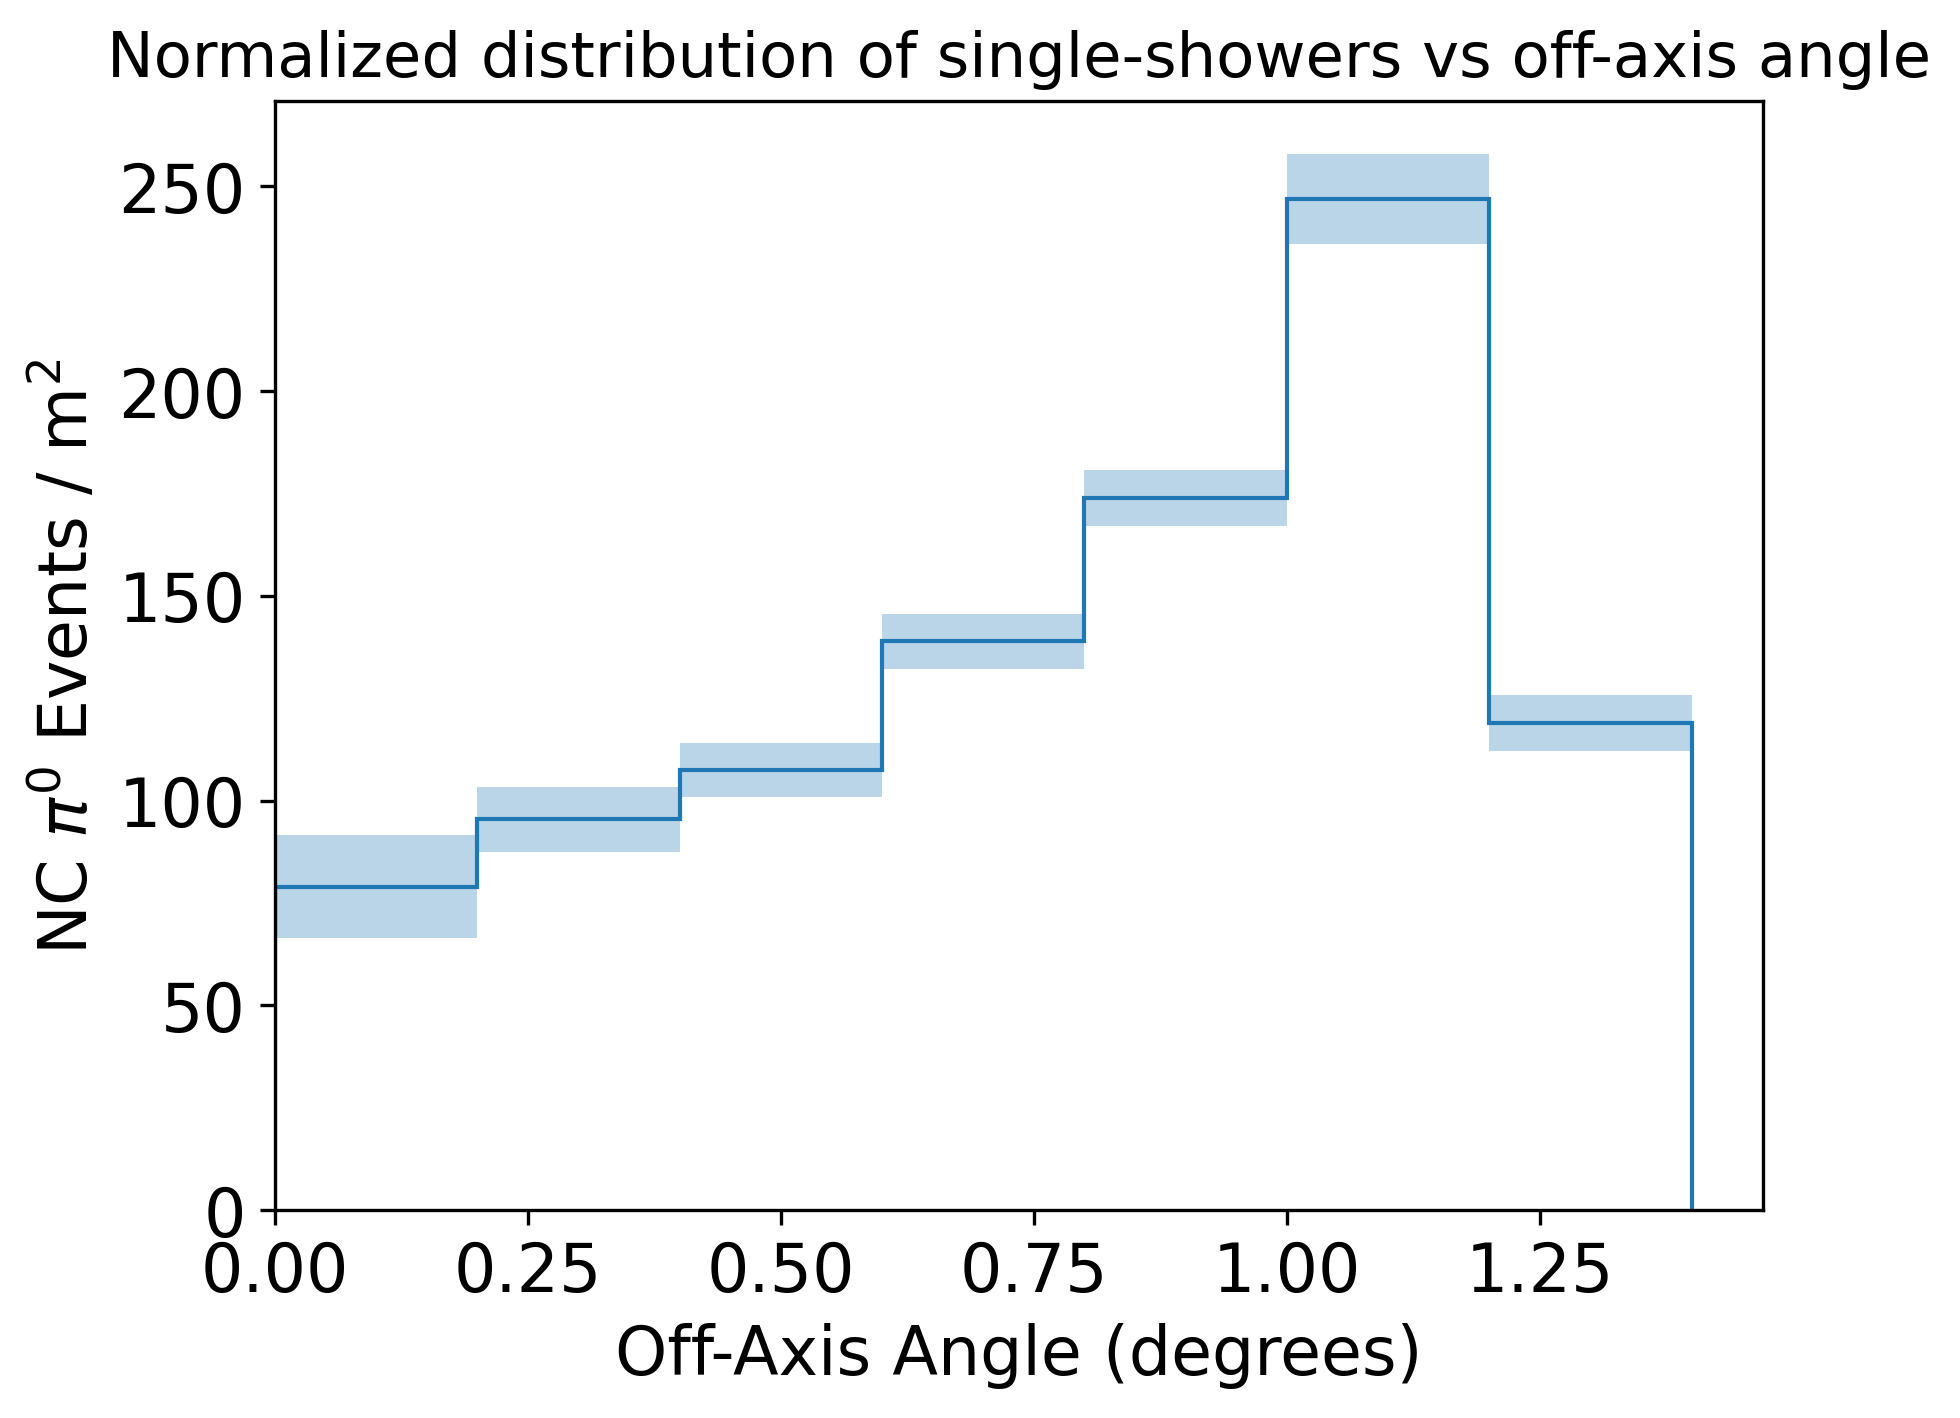

In [62]:
angles_norm_back = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    angles_norm_back = np.append(angles_norm_back, row['shower_angle_back'])
print(len(angles_norm_back))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles_norm_back, bins=nbinsTPC[:-1], histtype='step')
wide = np.diff(bins)
norm_counts = counts / norm_areas_back[:-1]
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / norm_areas_back[:-1]
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorTot)
plt.title(r'Normalized distribution of single-showers vs off-axis angle', fontsize = 15)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events / m$^2$')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

2571


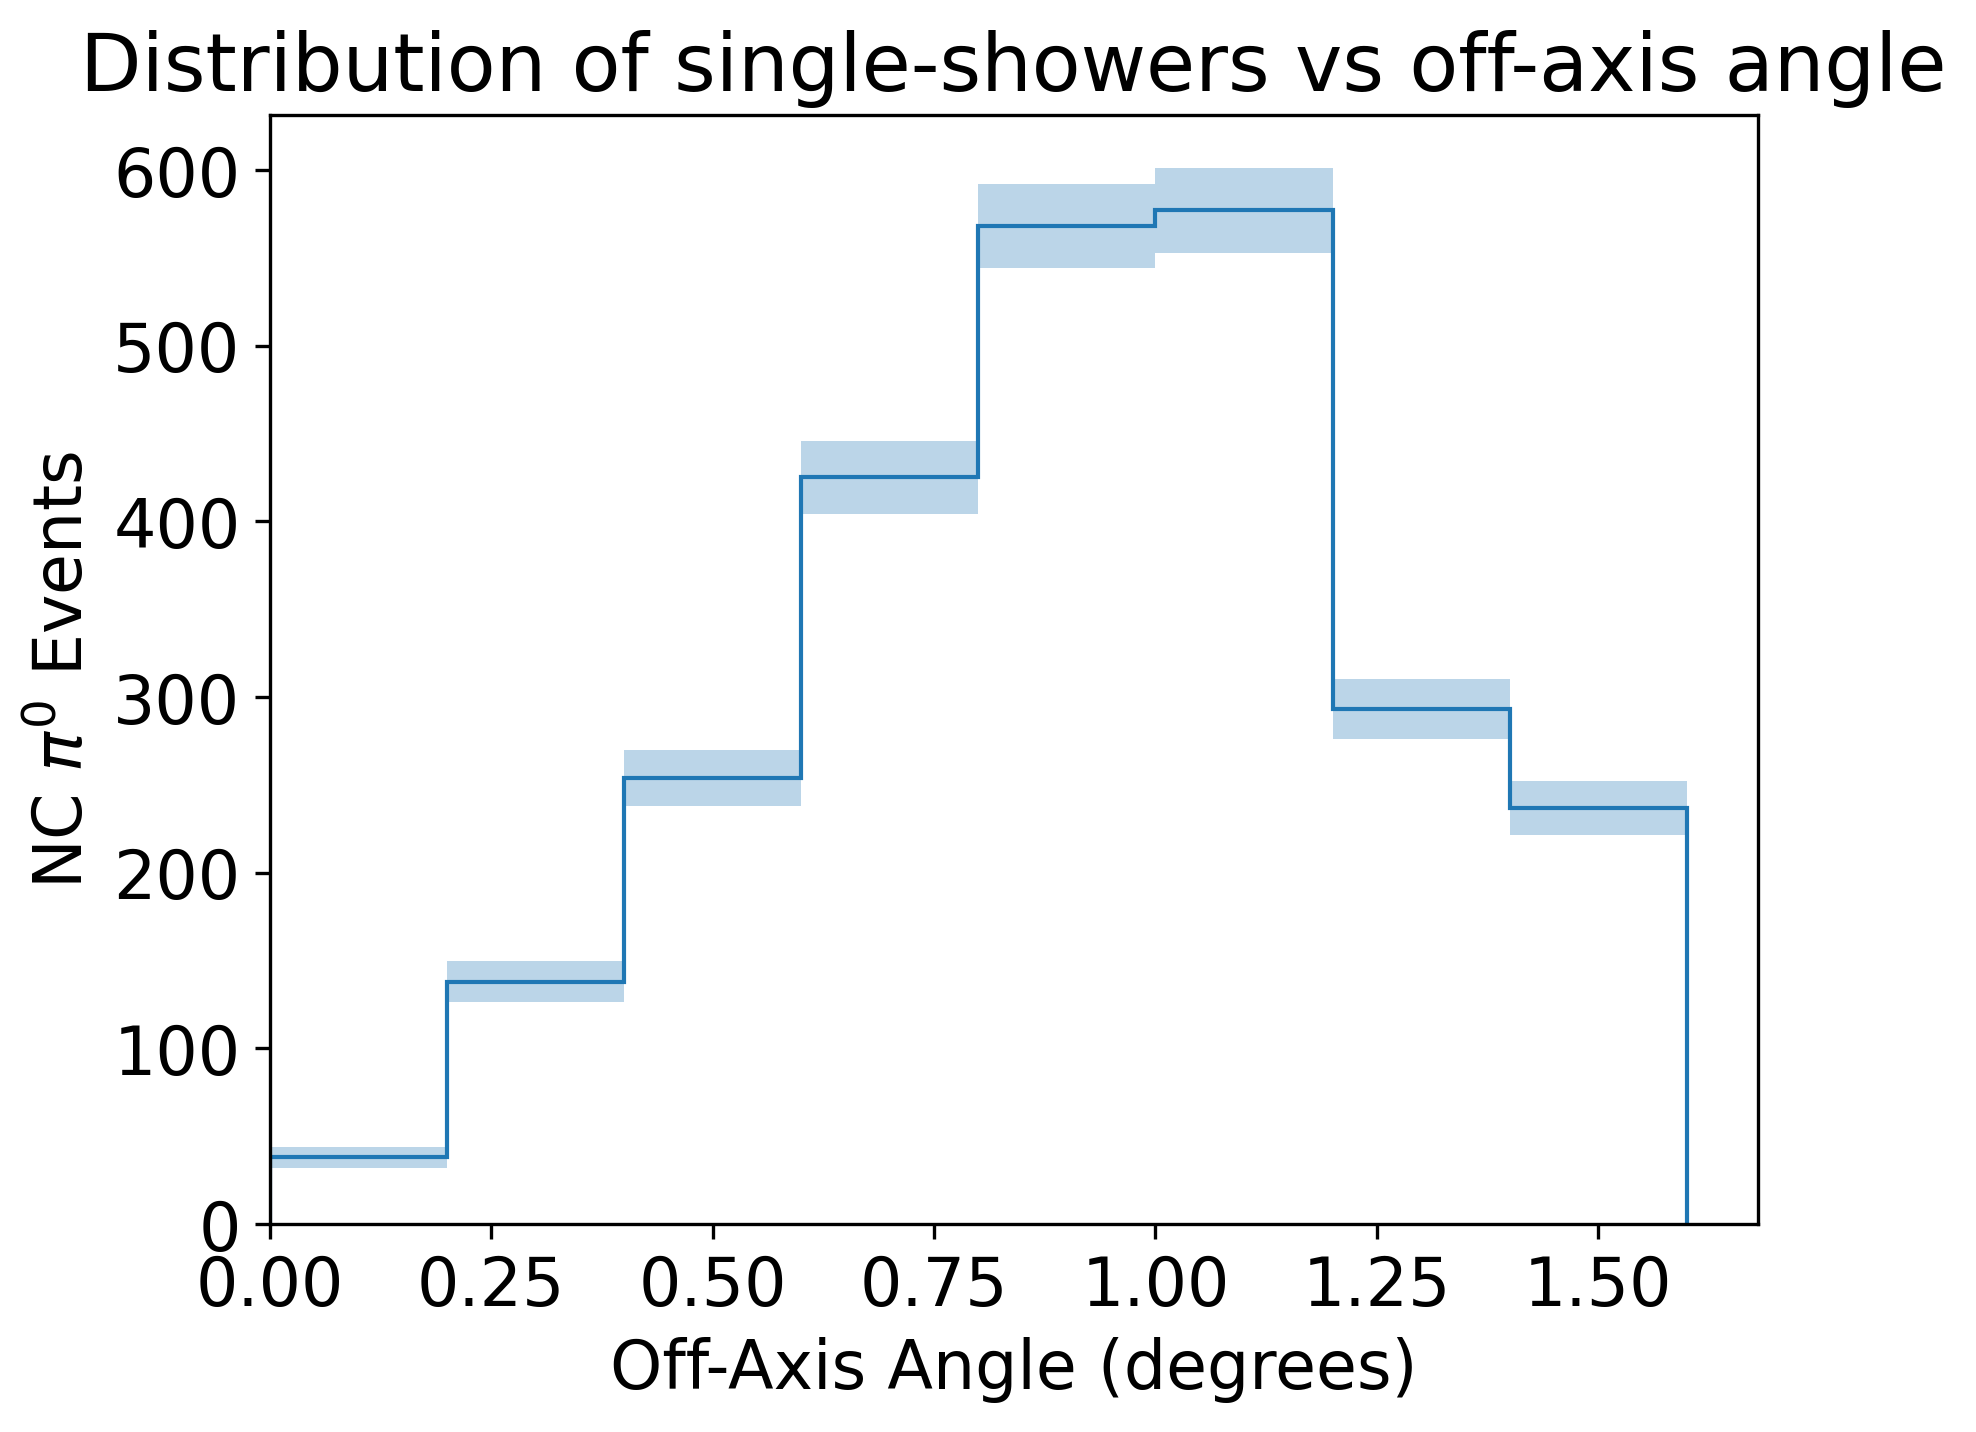

In [63]:
angles_exact = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    angles_exact = np.append(angles_exact, row['shower_angle_exact'])
print(len(angles_exact))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles_exact, bins=nbinsTPC, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot)
plt.title(r'Distribution of single-showers vs off-axis angle')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

2571


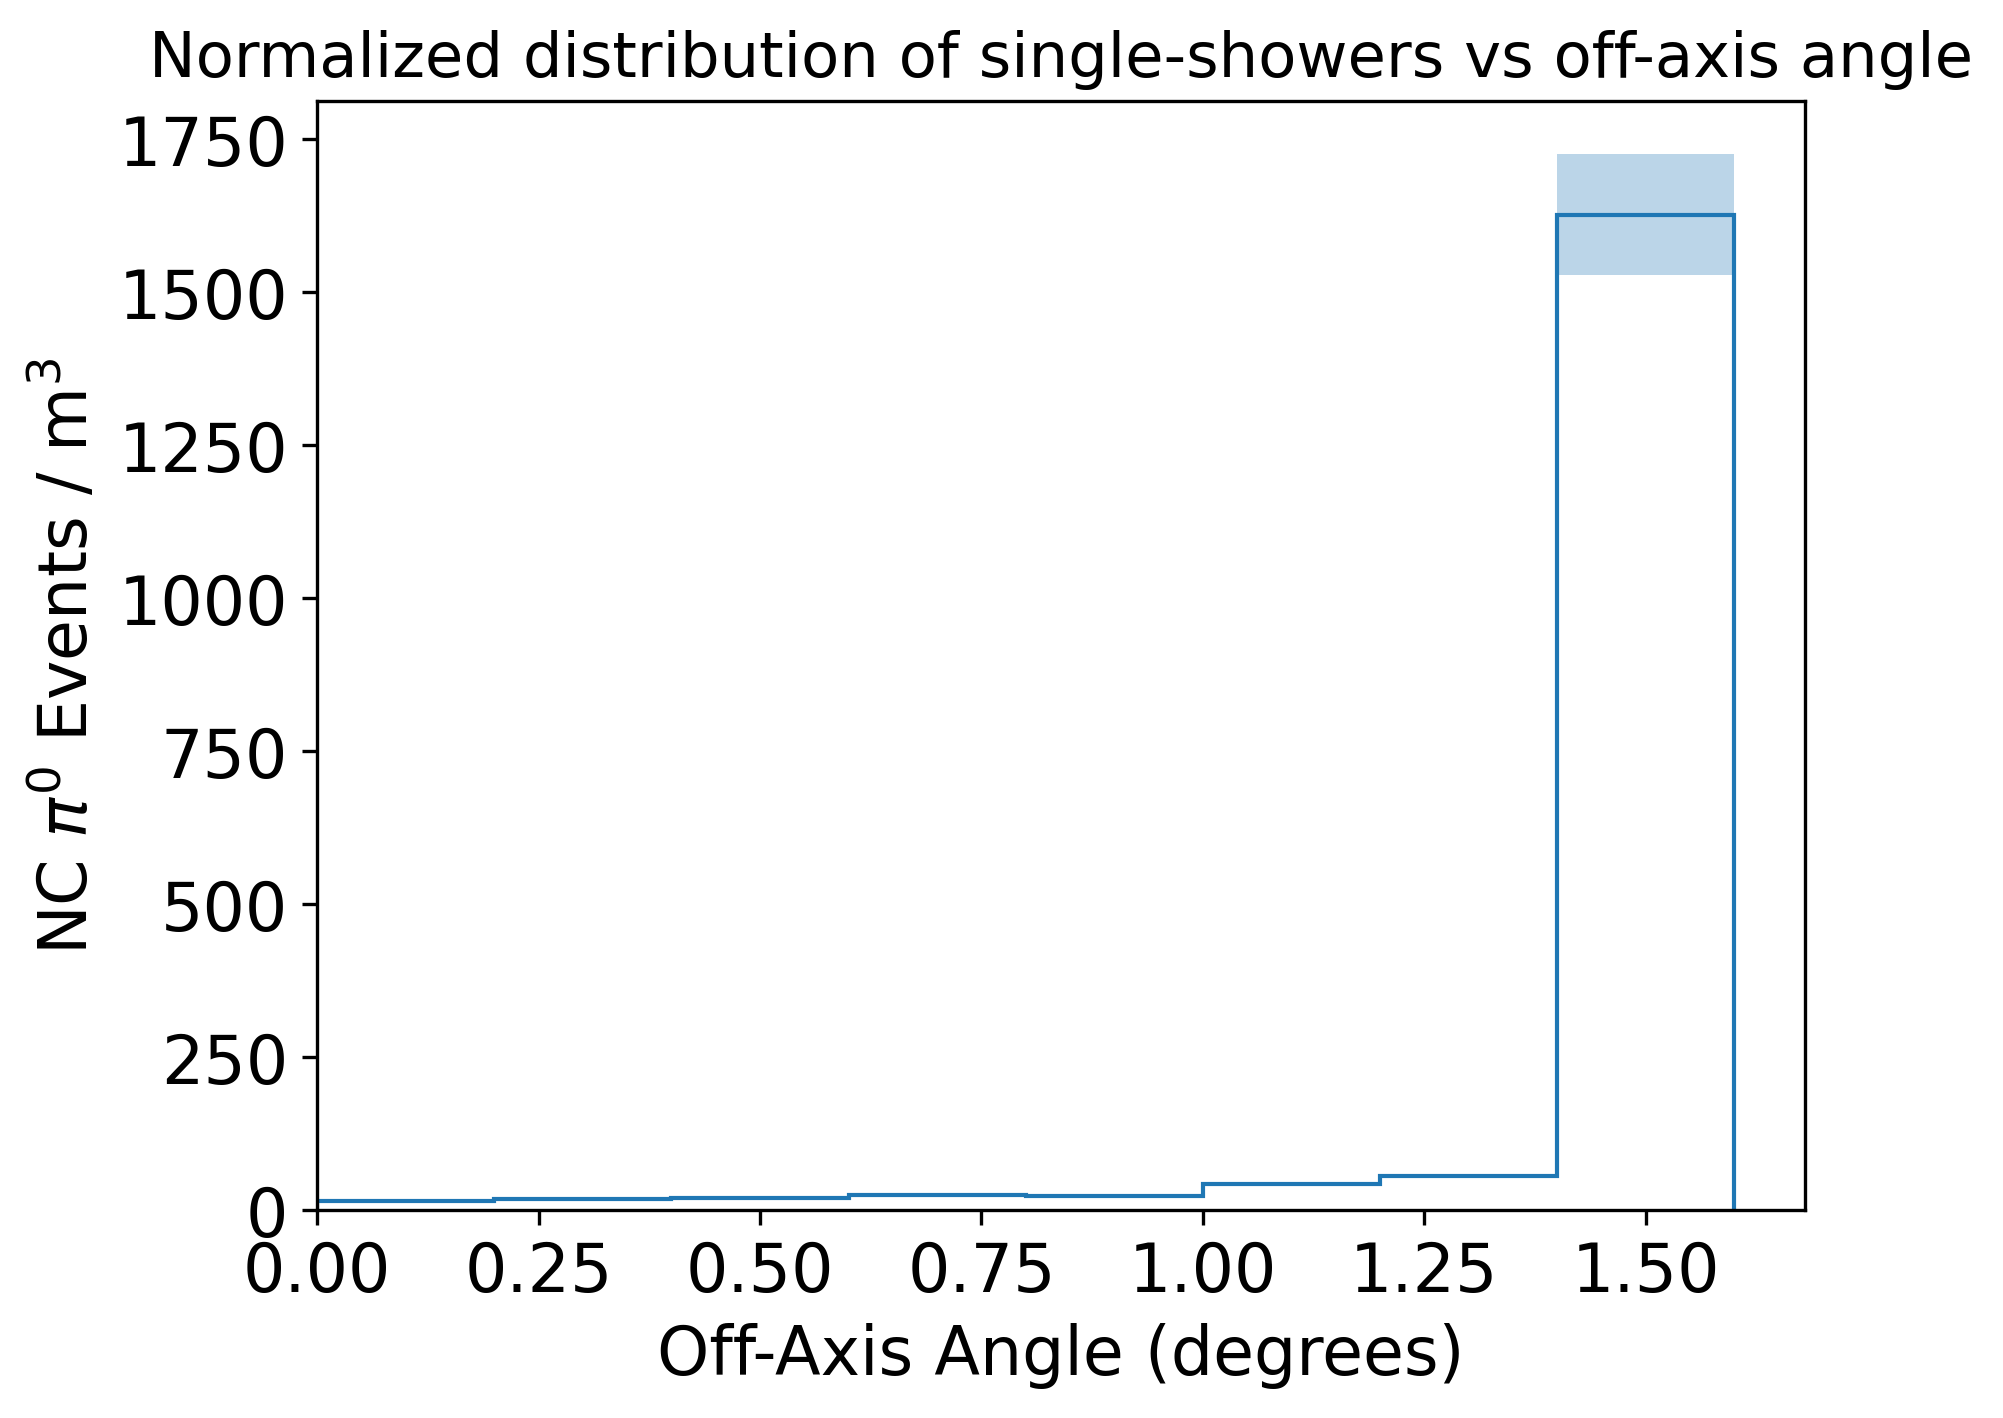

In [64]:
angles_norm_exact = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    angles_norm_exact = np.append(angles_norm_exact, row['shower_angle'])
print(len(angles_norm_exact))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles_norm_exact, bins=nbinsTPC, histtype='step')
wide = np.diff(bins)
norm_counts = counts / norm_vols
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / norm_vols
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorTot)
plt.title(r'Normalized distribution of single-showers vs off-axis angle', fontsize = 15)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events / m$^3$')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.show()

In [33]:
wc_df['pi0_angle'] = wc_df.apply(
    lambda row: [offAxAngle(row['StartPointx'][row['shower_pi0_dex'][i]], row['StartPointy'][row['shower_pi0_dex'][i]], 
                            row['StartPointz'][row['shower_pi0_dex'][i]], False, False) 
                 if row['N_showers'] > 0 else None for i in range(len(row['shower_pi0_dex']))],
    axis = 1
)

2571


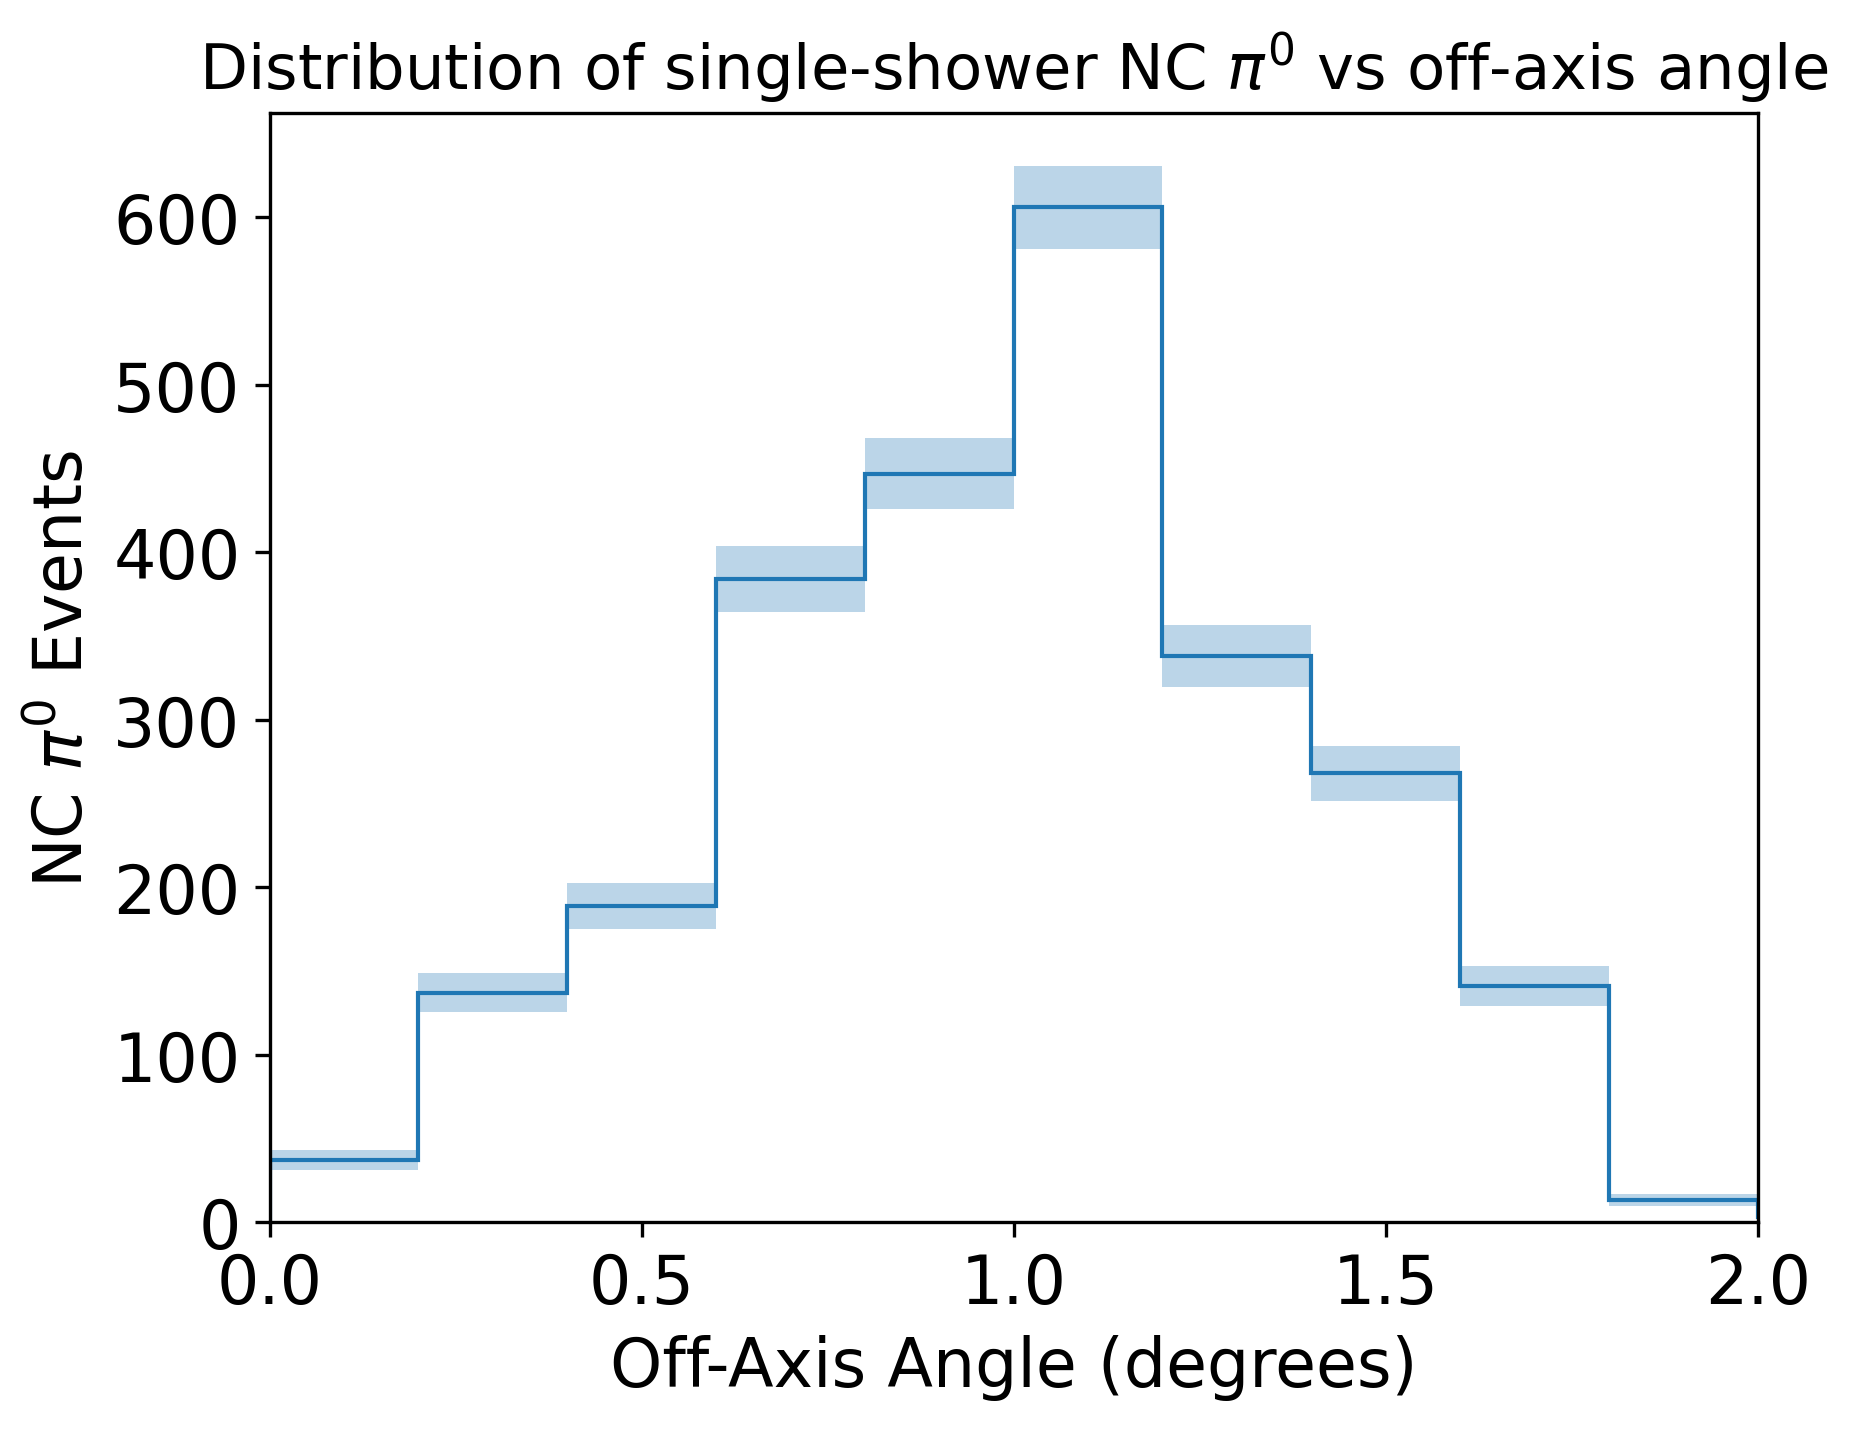

In [34]:
pi0Angles = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    pi0Angles = np.append(pi0Angles, row['pi0_angle'][0])
print(len(pi0Angles))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(pi0Angles, bins=nbins, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot)
plt.title(r'Distribution of single-shower NC $\pi^0$ vs off-axis angle', fontsize=15)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.ylim(*ylimit)
plt.xlim(0,2)
plt.show()

2571


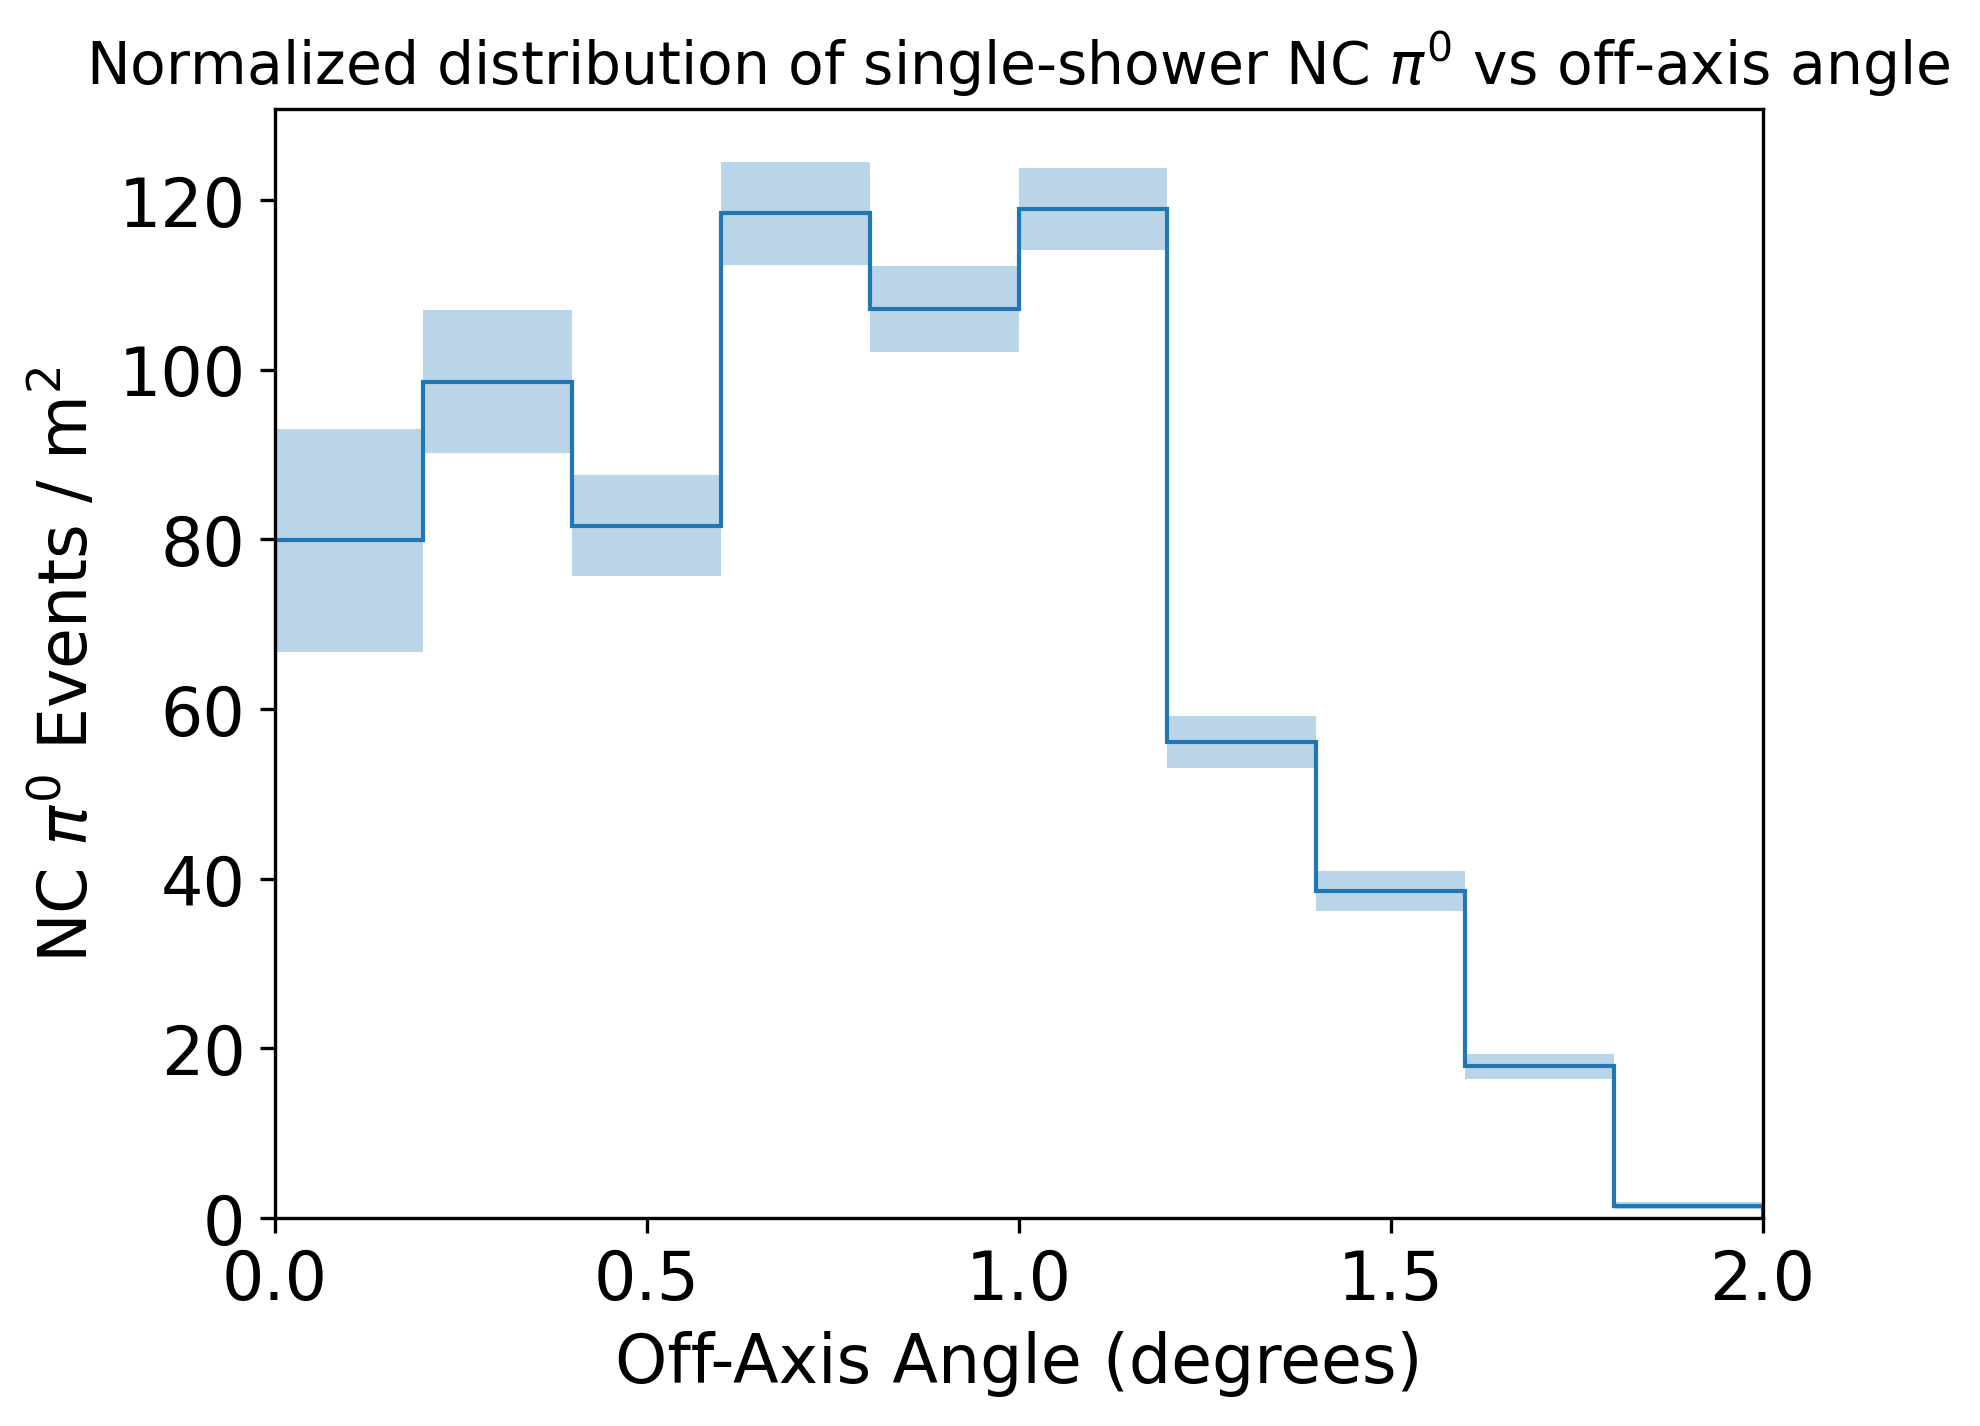

In [35]:
pi0_angles_norm = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    pi0_angles_norm = np.append(pi0_angles_norm, row['pi0_angle'][0])
print(len(pi0_angles_norm))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(pi0_angles_norm, bins=nbins, histtype='step')
wide = np.diff(bins)
bin_widths = np.diff(np.pi*((110*np.tan(bins*np.pi/180))**2))
norm_counts = counts / bin_widths  # normalize by bin width
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / bin_widths
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorTot)
plt.title(r'Normalized distribution of single-shower NC $\pi^0$ vs off-axis angle', fontsize = 14)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events / m$^2$')
plt.ylim(*ylimit)
plt.xlim(0,2)
plt.show()

11450


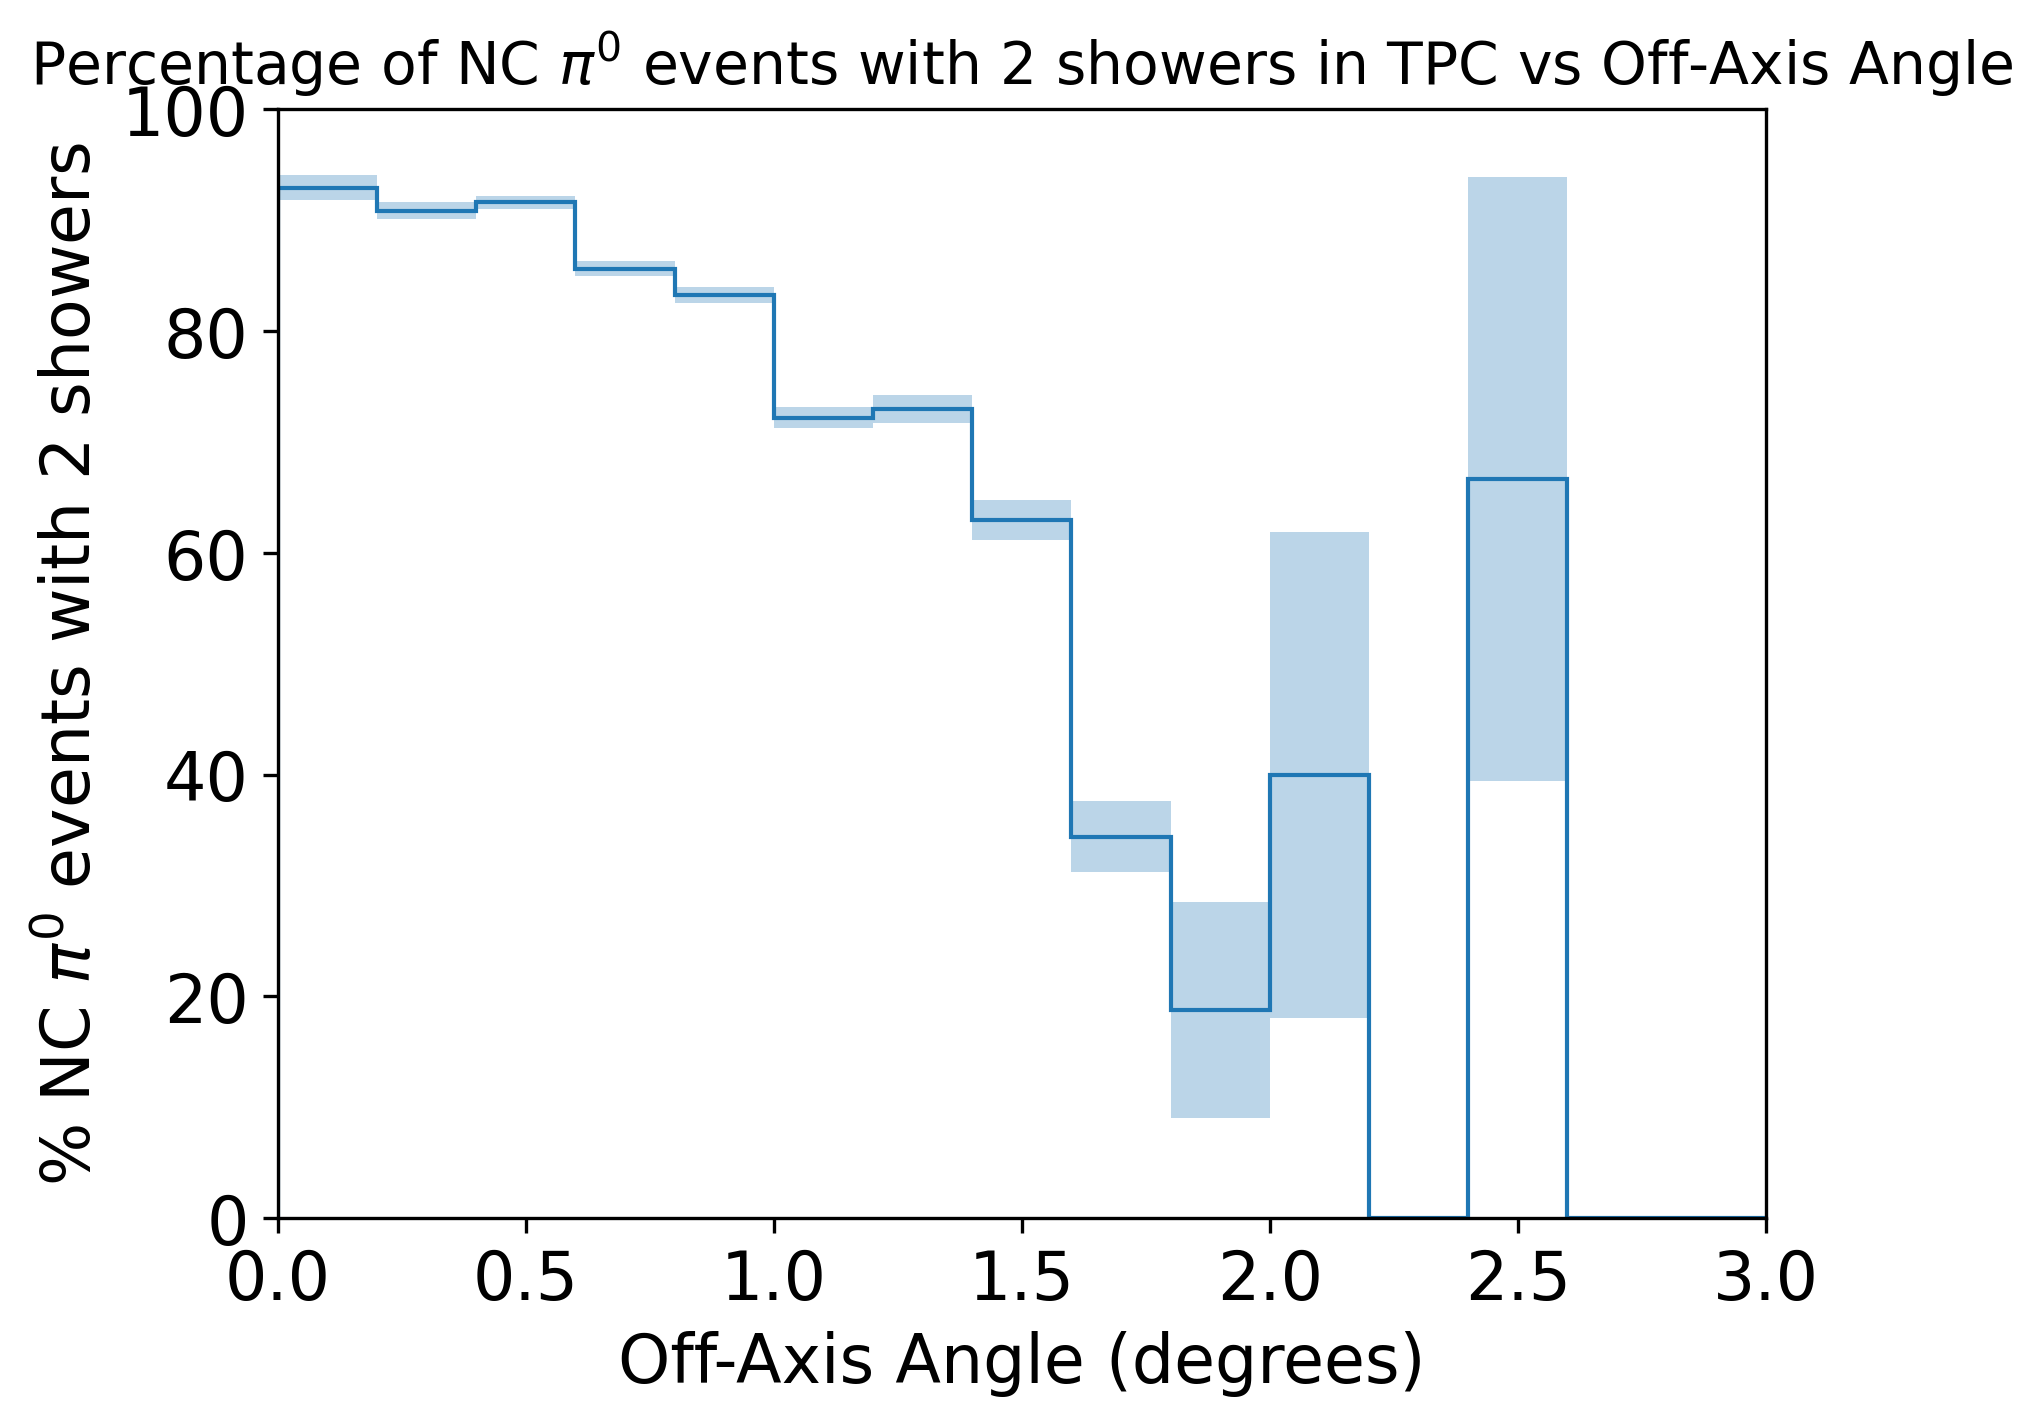

In [36]:
# make a plot of % of NCpi0 events which have 2 shower in TPC as function of NCpi0 vertex and off axis angle
pi0_angles_2 = np.array([])
for idx, row in wc_df[~CC_mask].iterrows():
    if row['N_showers'] == 2:
        pi0_angles_2 = np.append(pi0_angles_2, row['pi0_angle'])
print(len(pi0_angles_2))

# Calculate histogram for pi0_angles_NC and pi0Angles with the same bins
hist_2, _ = np.histogram(pi0_angles_2, bins=nbins)
hist_nc, _ = np.histogram(pi0Angles, bins=nbins)

# Calculate the fraction for each bin
fraction = 100*hist_2/(hist_nc + hist_2 + 1e-10)
errors = 100*np.divide(np.sqrt(np.add(np.square(np.multiply(hist_nc, np.sqrt(hist_2))), 
                                      np.square(np.multiply(hist_2, np.sqrt(hist_nc))))), 
                       np.square(np.add(hist_nc, hist_2)+1e-10))

# Plot the histogram
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.figure(dpi=300)
plt.bar(bin_centers, 2*errors, width=np.diff(bins), bottom=fraction-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=fraction, histtype='step', color=colorTot)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel('% NC $\pi^0$ events with 2 showers')
plt.title('Percentage of NC $\pi^0$ events with 2 showers in TPC vs Off-Axis Angle', fontsize=14)
plt.ylim(0, 100)
plt.xlim(0,3)
plt.show()

12276


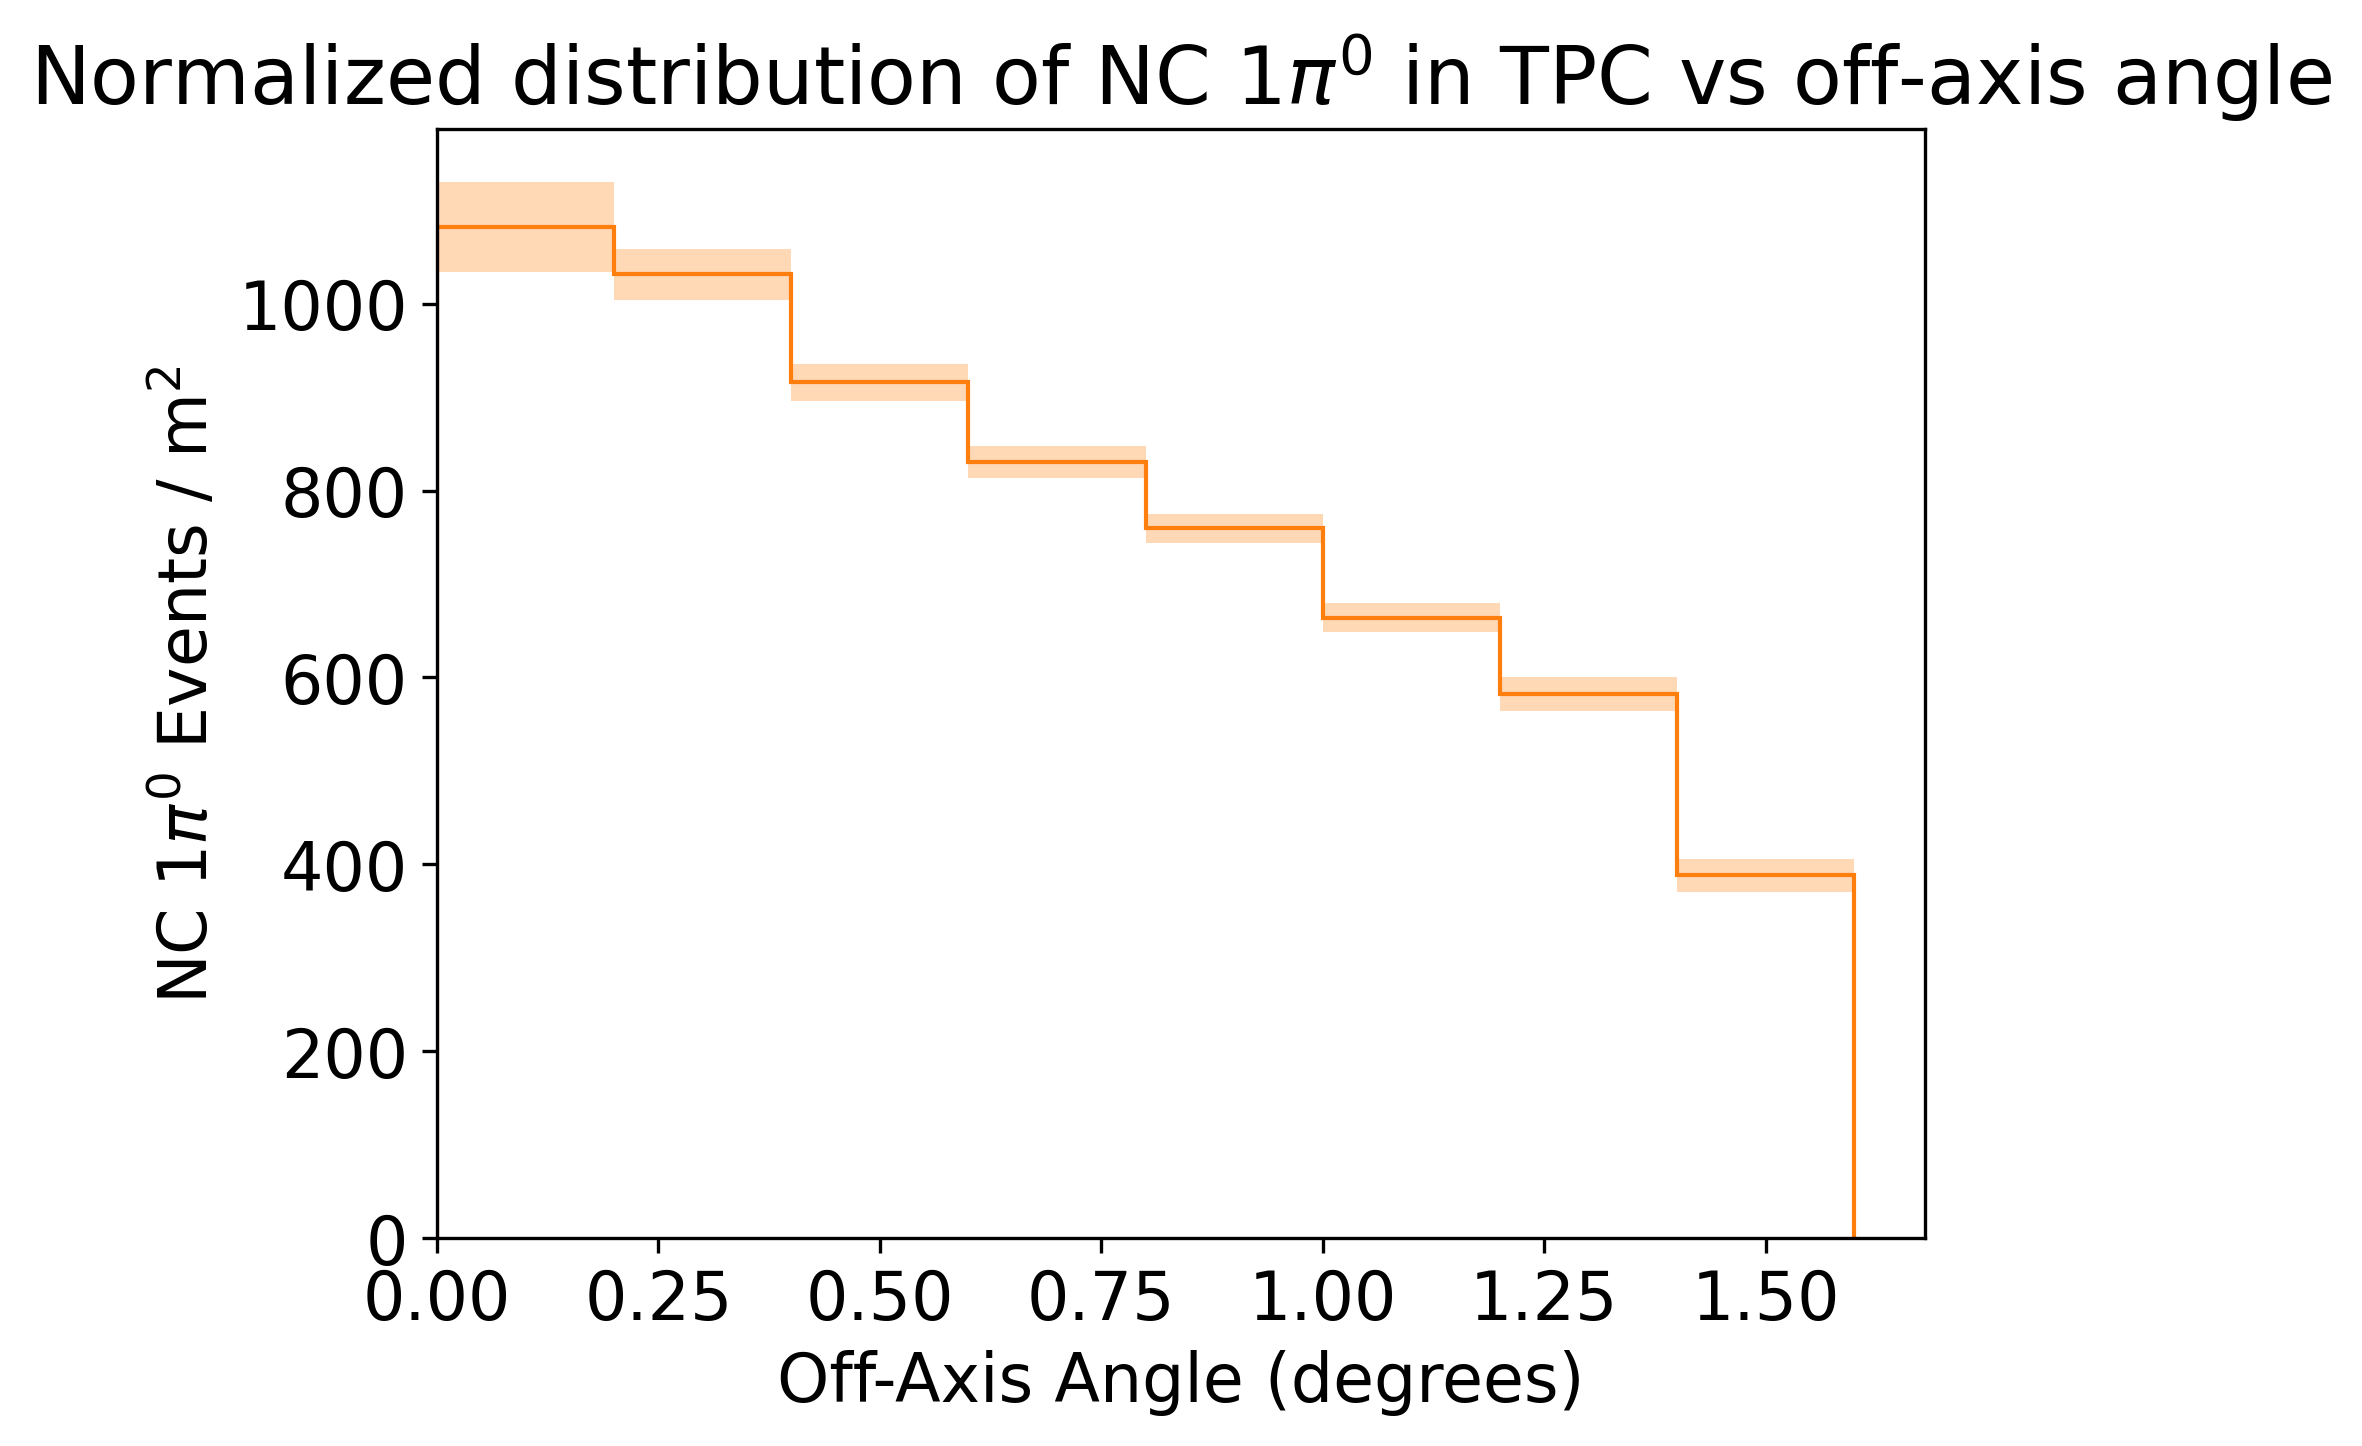

In [37]:
pi0_angles_tot = np.array([])
for idx, row in wc_df[~CC_mask & NC1pi0_mask].iterrows():
    if len(row['pi0_angle']) > 0:
        if row['in_TPC_g4'][0]:
            pi0_angles_tot = np.append(pi0_angles_tot, row['pi0_angle'][0])
print(len(pi0_angles_tot))

plt.figure(dpi=300)
counts, bins, _ = plt.hist(pi0_angles_tot, bins=nbinsTPC, histtype='step')
wide = np.diff(bins)
norm_counts = counts / norm_areas
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / norm_areas
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorP)
plt.title(r'Normalized distribution of NC $1\pi^0$ in TPC vs off-axis angle')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $1\pi^0$ Events / m$^2$')
plt.ylim(*ylimit)
plt.xlim(*xlimit)
plt.show()

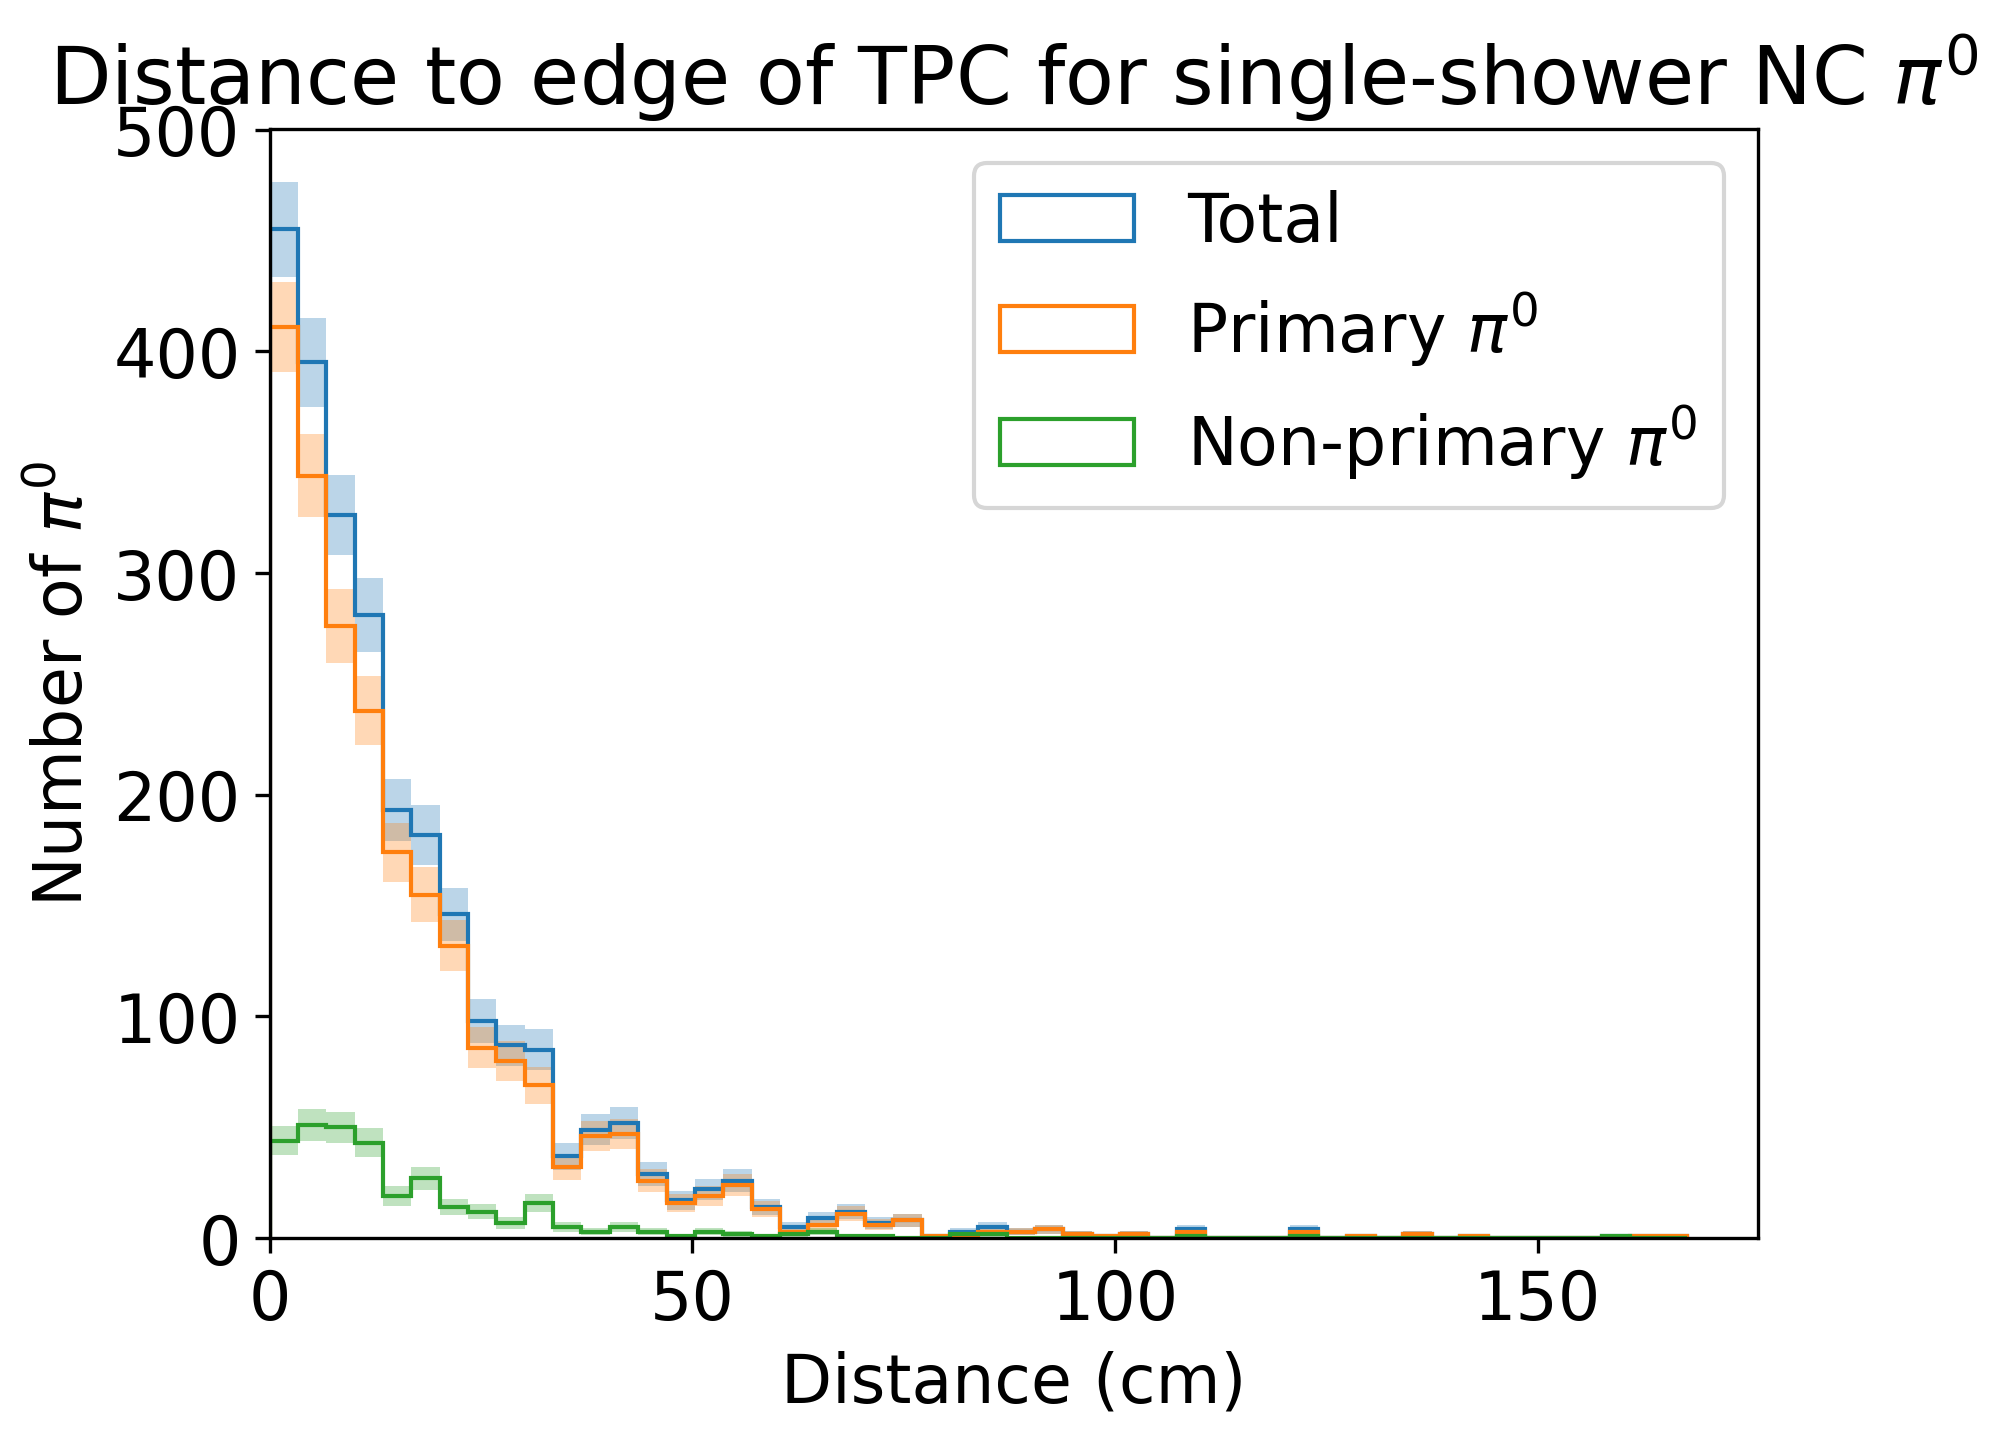

In [38]:
distancesNP = np.array([])
distancesP = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    for k in range(len(row['shower_pi0_dex'])):
        if row['shower_pi0_dex'][k] == 0:
            distancesP = np.append(distancesP, row['dist_to_edge_g4'][row['shower_pi0_dex'][k]])
        else:
            distancesNP = np.append(distancesNP, row['dist_to_edge_g4'][row['shower_pi0_dex'][k]])
assert len(distancesP)+len(distancesNP) == len(distances)

plt.figure(dpi=300)
counts, bins, _ = plt.hist(distances, bins=50, histtype='step')
cP, bP, _ = plt.hist(distancesP, bins=bins, histtype='step')
cNP, bNP, _ = plt.hist(distancesNP, bins=bins, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
errP = np.sqrt(cP)
errNP = np.sqrt(cNP)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=wide, bottom=cP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=cP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=wide, bottom=cNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=cNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.title(r'Distance to edge of TPC for single-shower NC $\pi^0$')
plt.xlabel('Distance (cm)')
plt.ylabel(r'Number of $\pi^0$')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.legend()
plt.show()

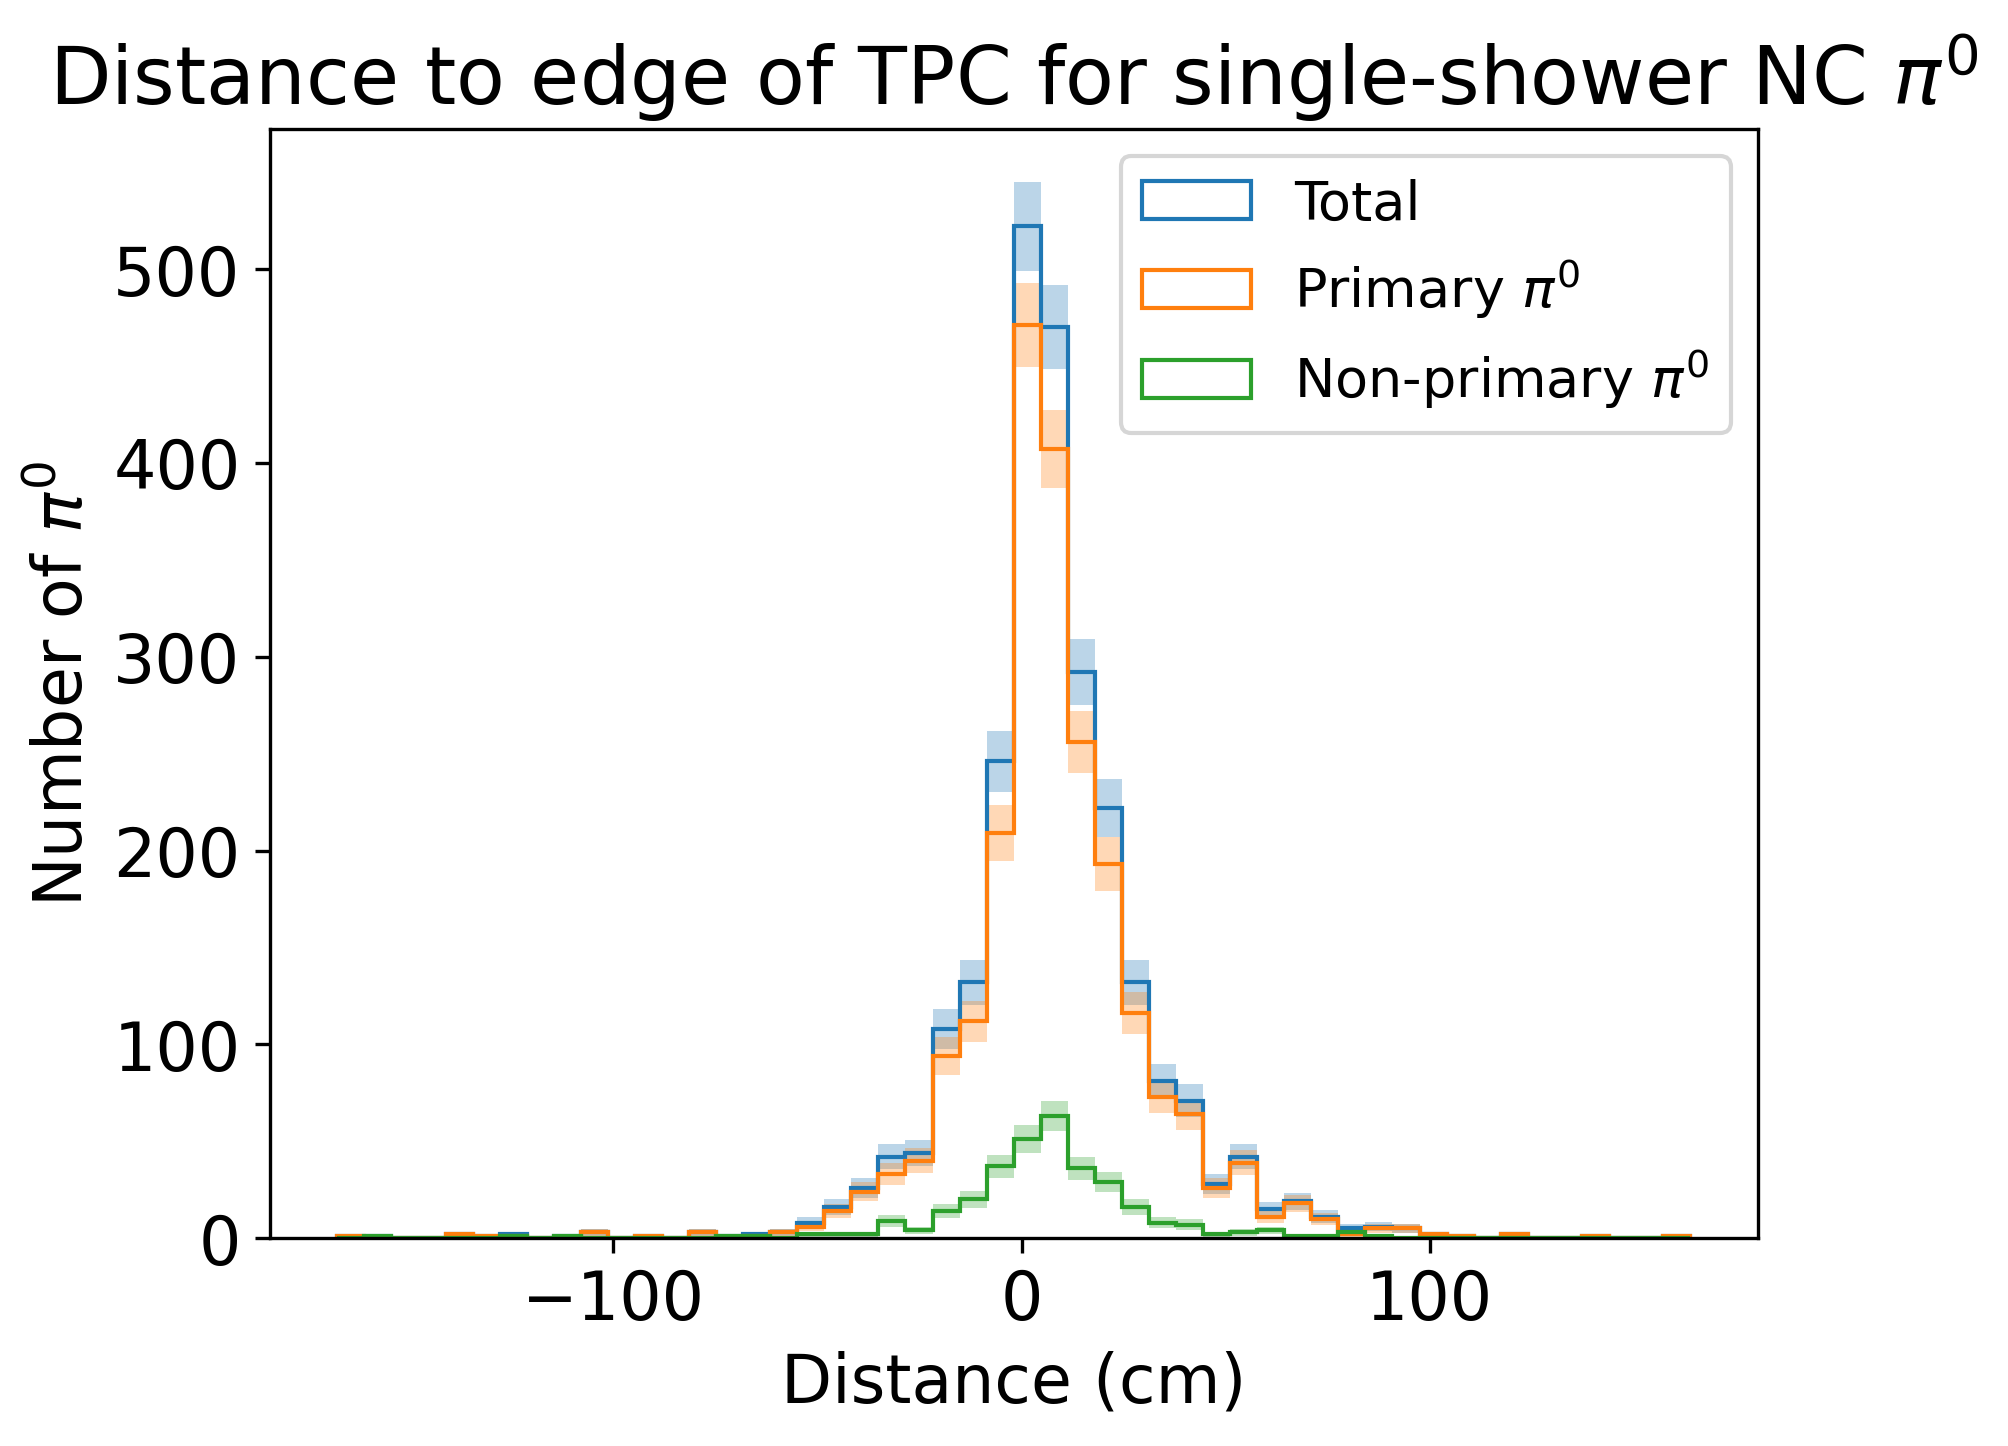

In [39]:
distancesNPSig = np.array([])
distancesPSig = np.array([])
distancesSig = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    for k in range(len(row['shower_pi0_dex'])):
        distancesSig = np.append(distancesSig, row['signed_dist_to_edge_g4'][row['shower_pi0_dex'][k]])
        if row['shower_pi0_dex'][k] == 0:
            distancesPSig = np.append(distancesPSig, row['signed_dist_to_edge_g4'][row['shower_pi0_dex'][k]])
        else:
            distancesNPSig = np.append(distancesNPSig, row['signed_dist_to_edge_g4'][row['shower_pi0_dex'][k]])
assert len(distancesPSig)+len(distancesNPSig) == len(distancesSig)

plt.figure(dpi=300)
counts, bins, _ = plt.hist(distancesSig, bins=50, histtype='step')
cP, bP, _ = plt.hist(distancesPSig, bins=bins, histtype='step')
cNP, bNP, _ = plt.hist(distancesNPSig, bins=bins, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
errP = np.sqrt(cP)
errNP = np.sqrt(cNP)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=wide, bottom=cP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=cP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=wide, bottom=cNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=cNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.title(r'Distance to edge of TPC for single-shower NC $\pi^0$')
plt.xlabel('Distance (cm)')
plt.ylabel(r'Number of $\pi^0$')
#plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.legend(prop={'size': 13})
plt.show()

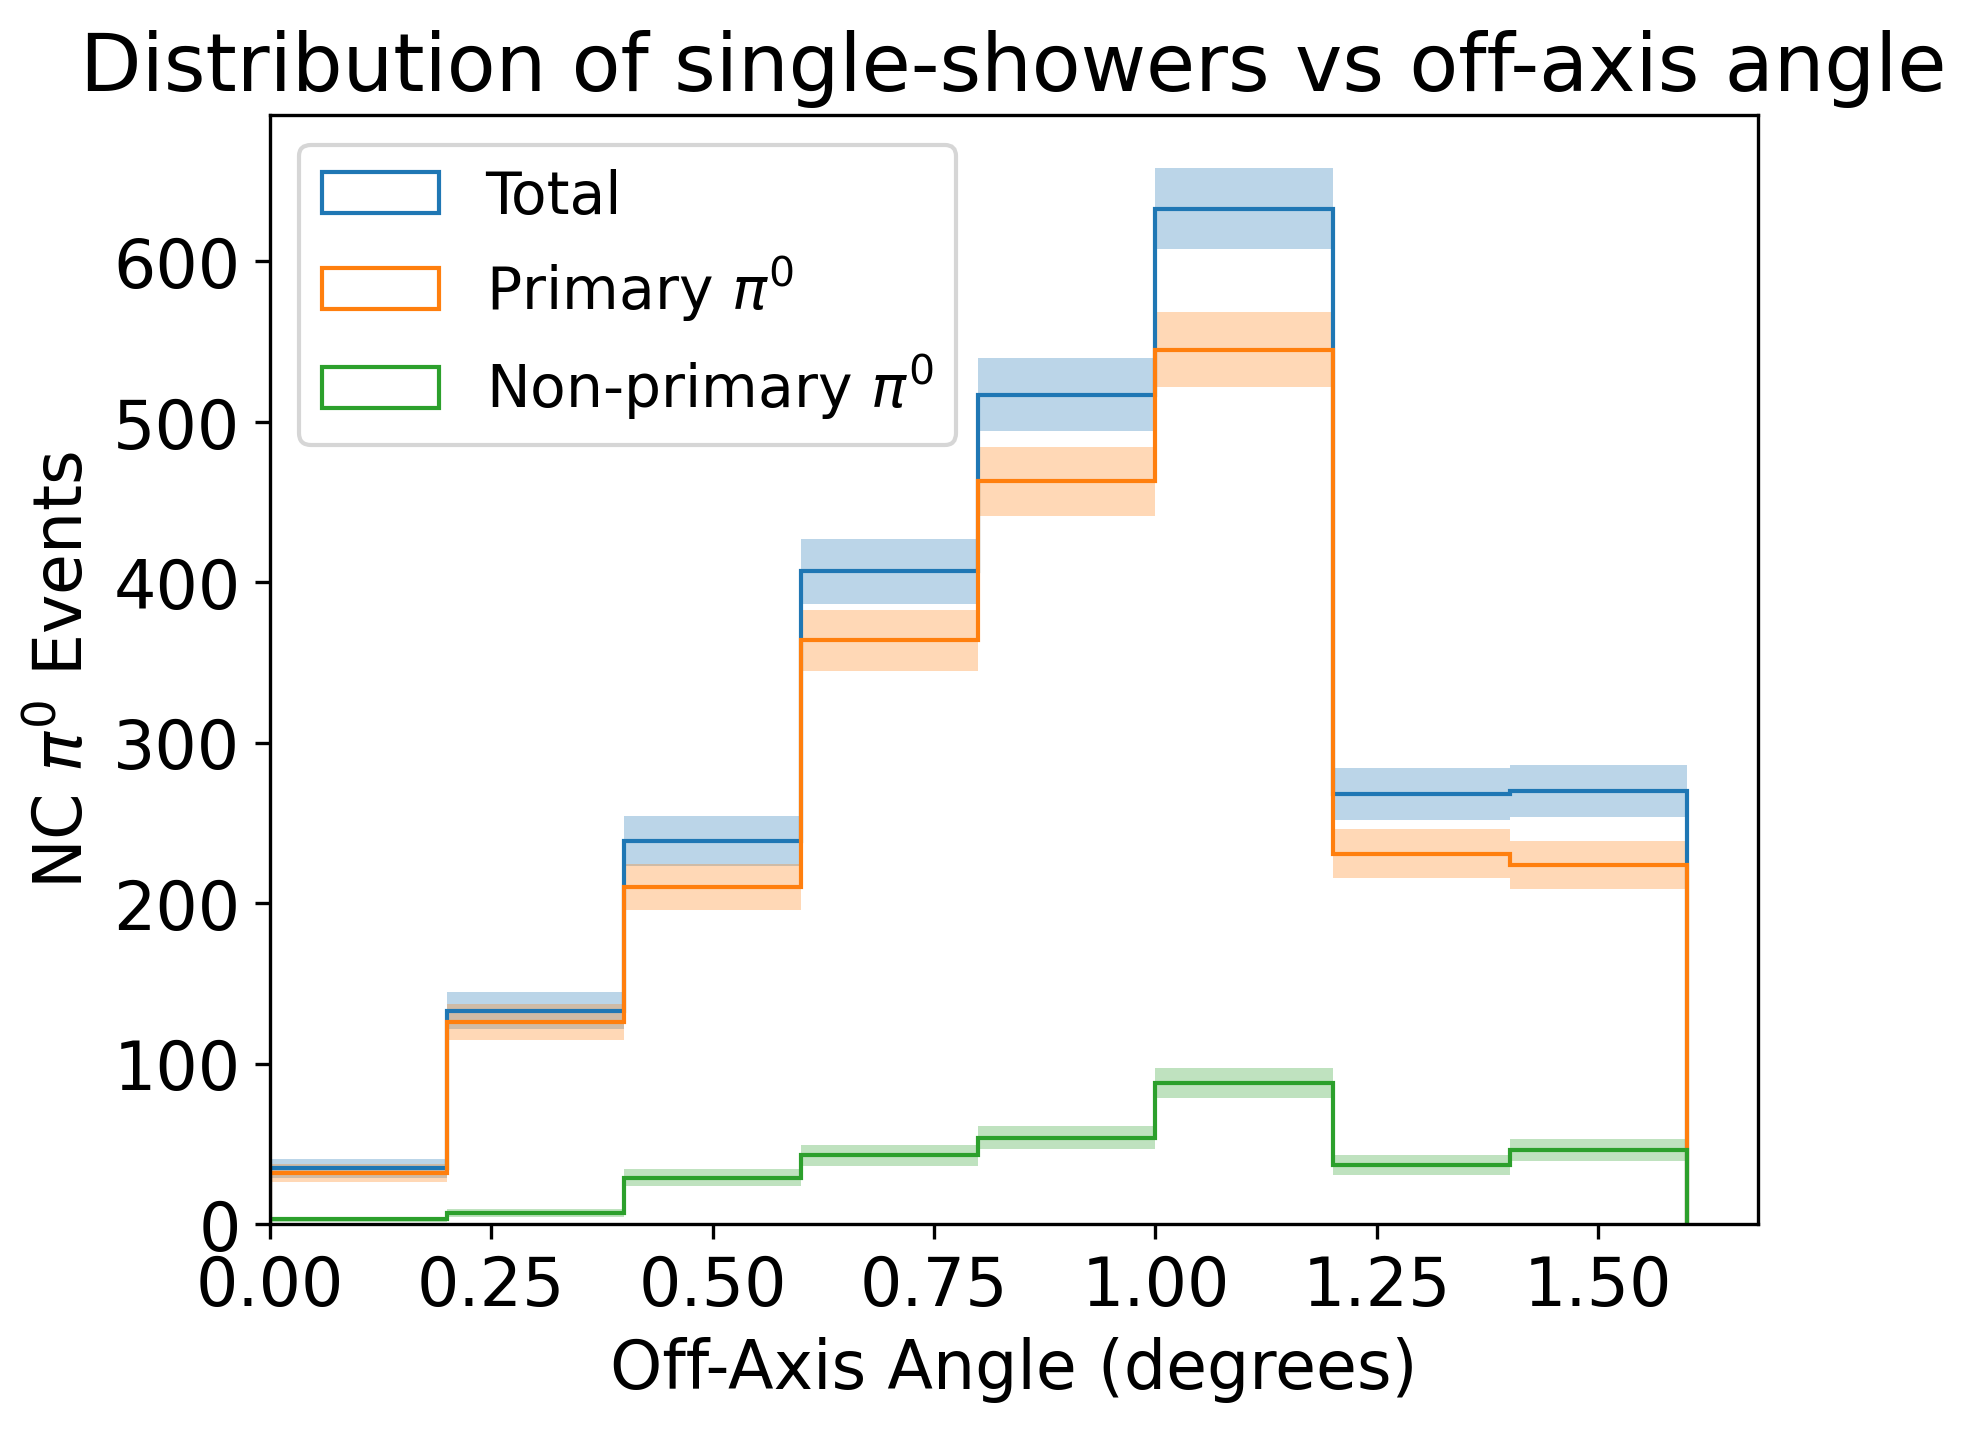

In [40]:
anglesP = np.array([])
anglesNP = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    for k in range(len(row['shower_pi0_dex'])):
        if row['shower_pi0_dex'][k] == 0:
            anglesP = np.append(anglesP, row['shower_angle'])
        else:
            anglesNP = np.append(anglesNP, row['shower_angle'])
assert len(anglesP)+len(anglesNP) == len(angles)

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles, bins=nbinsTPC, histtype='step')
caP, baP, _ = plt.hist(anglesP, bins=bins, histtype='step')
caNP, baNP, _ = plt.hist(anglesNP, bins=bins, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
errP = np.sqrt(caP)
errNP = np.sqrt(caNP)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=wide, bottom=caP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=caP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=wide, bottom=caNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=caNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.title(r'Distribution of single-showers vs off-axis angle')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.xlim(*xlimit)
plt.ylim(*ylimit)
plt.legend(prop={'size':14})
plt.show()

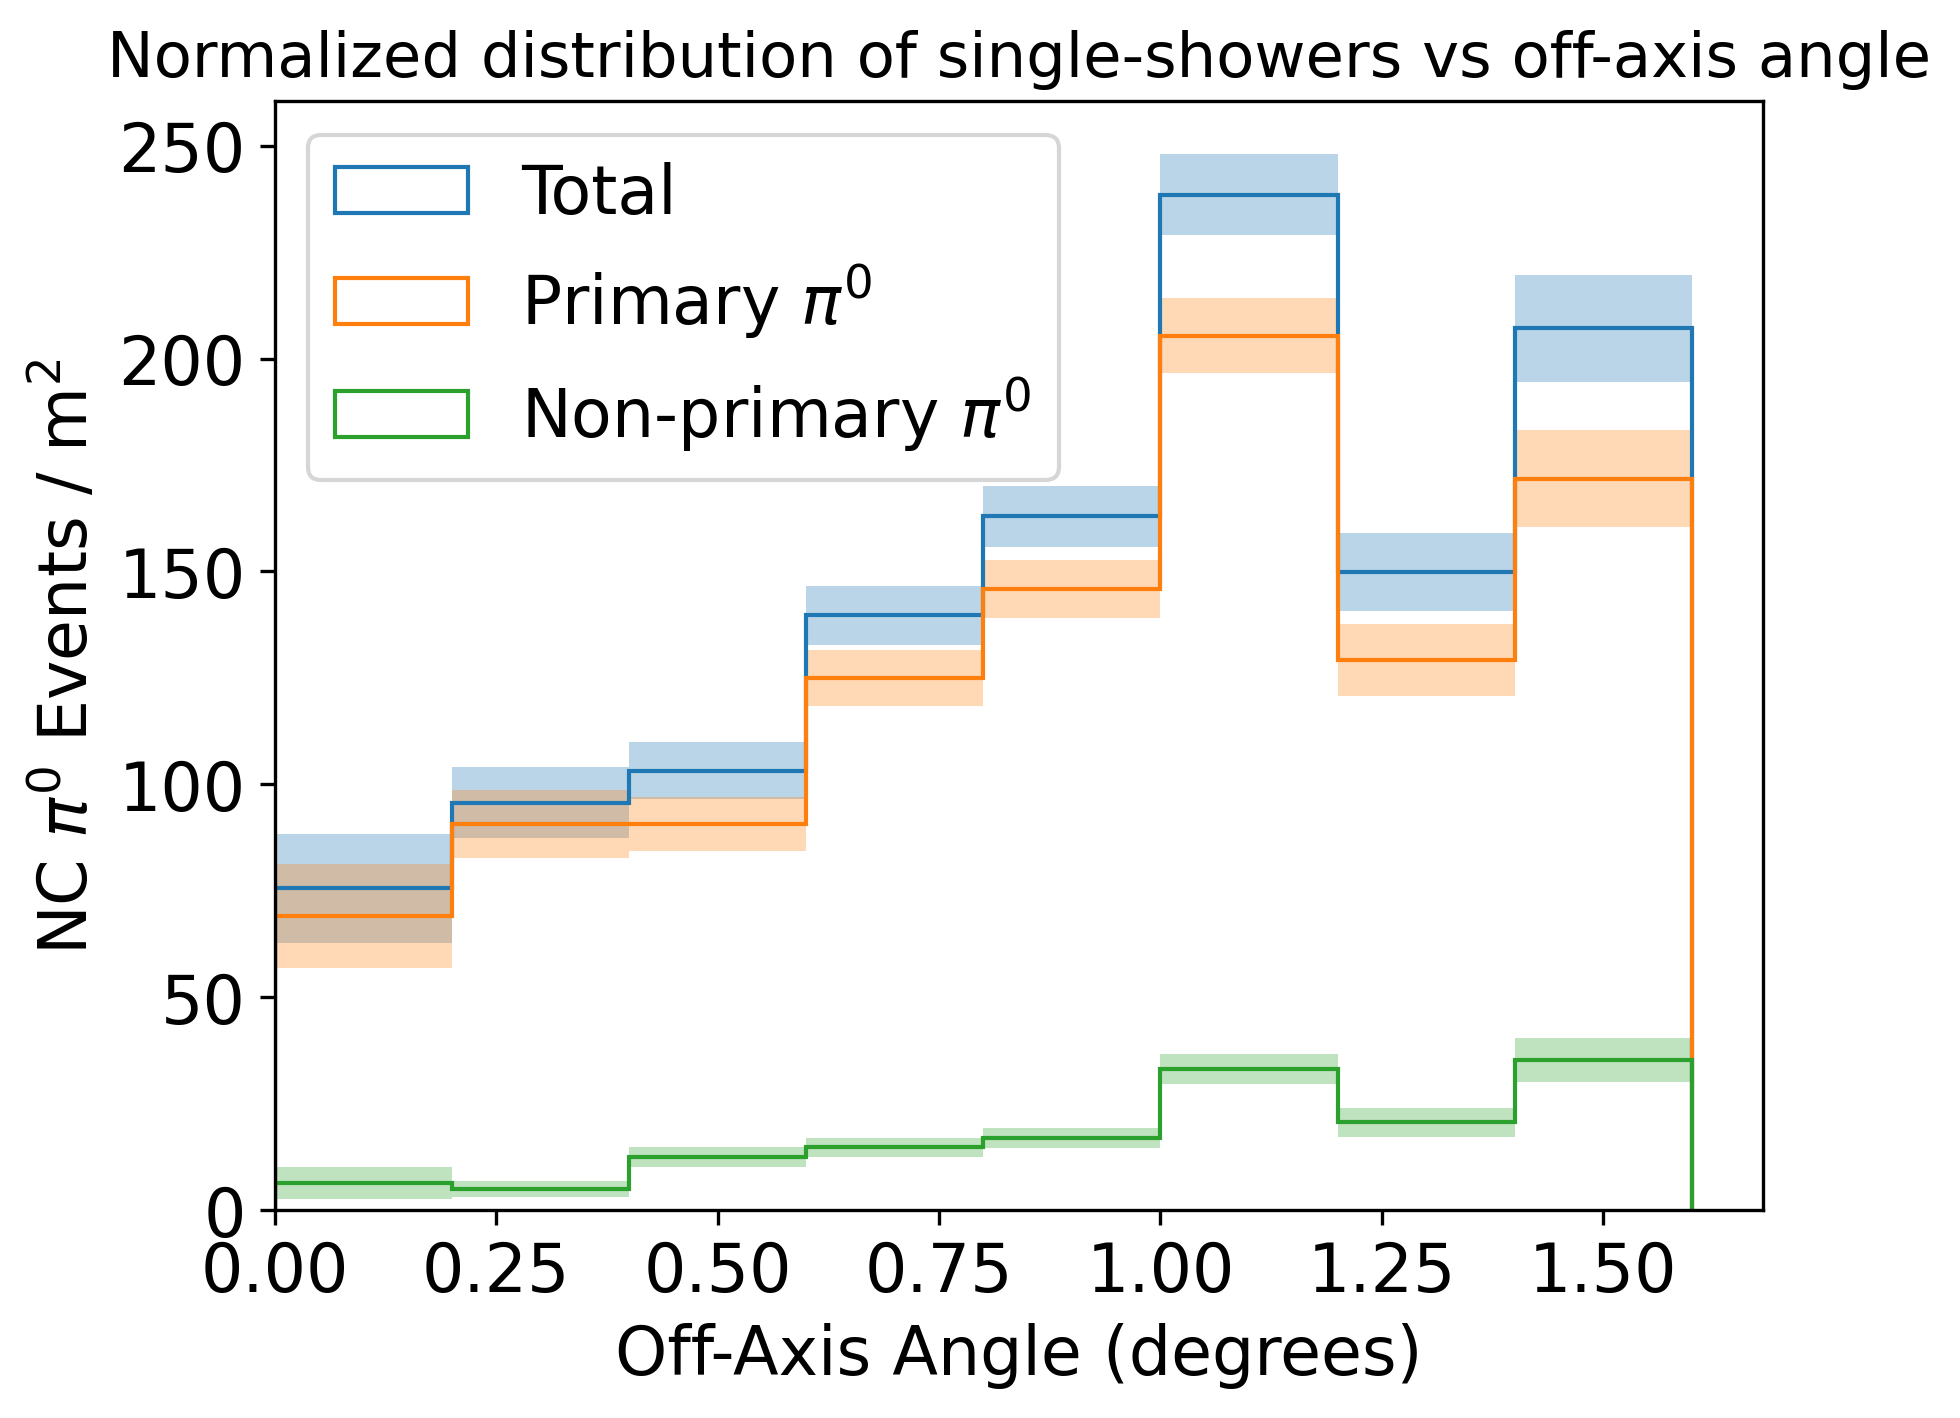

In [41]:
angles_normP = np.array([])
angles_normNP = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    for k in range(len(row['shower_pi0_dex'])):
        if row['shower_pi0_dex'][k] == 0:
            angles_normP = np.append(angles_normP, row['shower_angle'])
        else:
            angles_normNP = np.append(angles_normNP, row['shower_angle'])
assert len(angles_norm) == len(angles_normP) + len(angles_normNP)

plt.figure(dpi=300)
counts, bins, _ = plt.hist(angles_norm, bins=nbinsTPC, histtype='step')
cP, bP, _ = plt.hist(angles_normP, bins=bins, histtype='step')
cNP, bNP, _ = plt.hist(angles_normNP, bins=bins, histtype='step')
wide = np.diff(bins)
norm_counts = counts / norm_areas
ncP = cP / norm_areas
ncNP = cNP / norm_areas
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / norm_areas
errP = np.sqrt(cP) / norm_areas
errNP = np.sqrt(cNP) / norm_areas
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=wide, bottom=ncP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=ncP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=wide, bottom=ncNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=ncNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.title(r'Normalized distribution of single-showers vs off-axis angle', fontsize = 15)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events / m$^2$')
plt.ylim(*ylimit)
plt.xlim(*xlimit)
plt.legend()
plt.show()

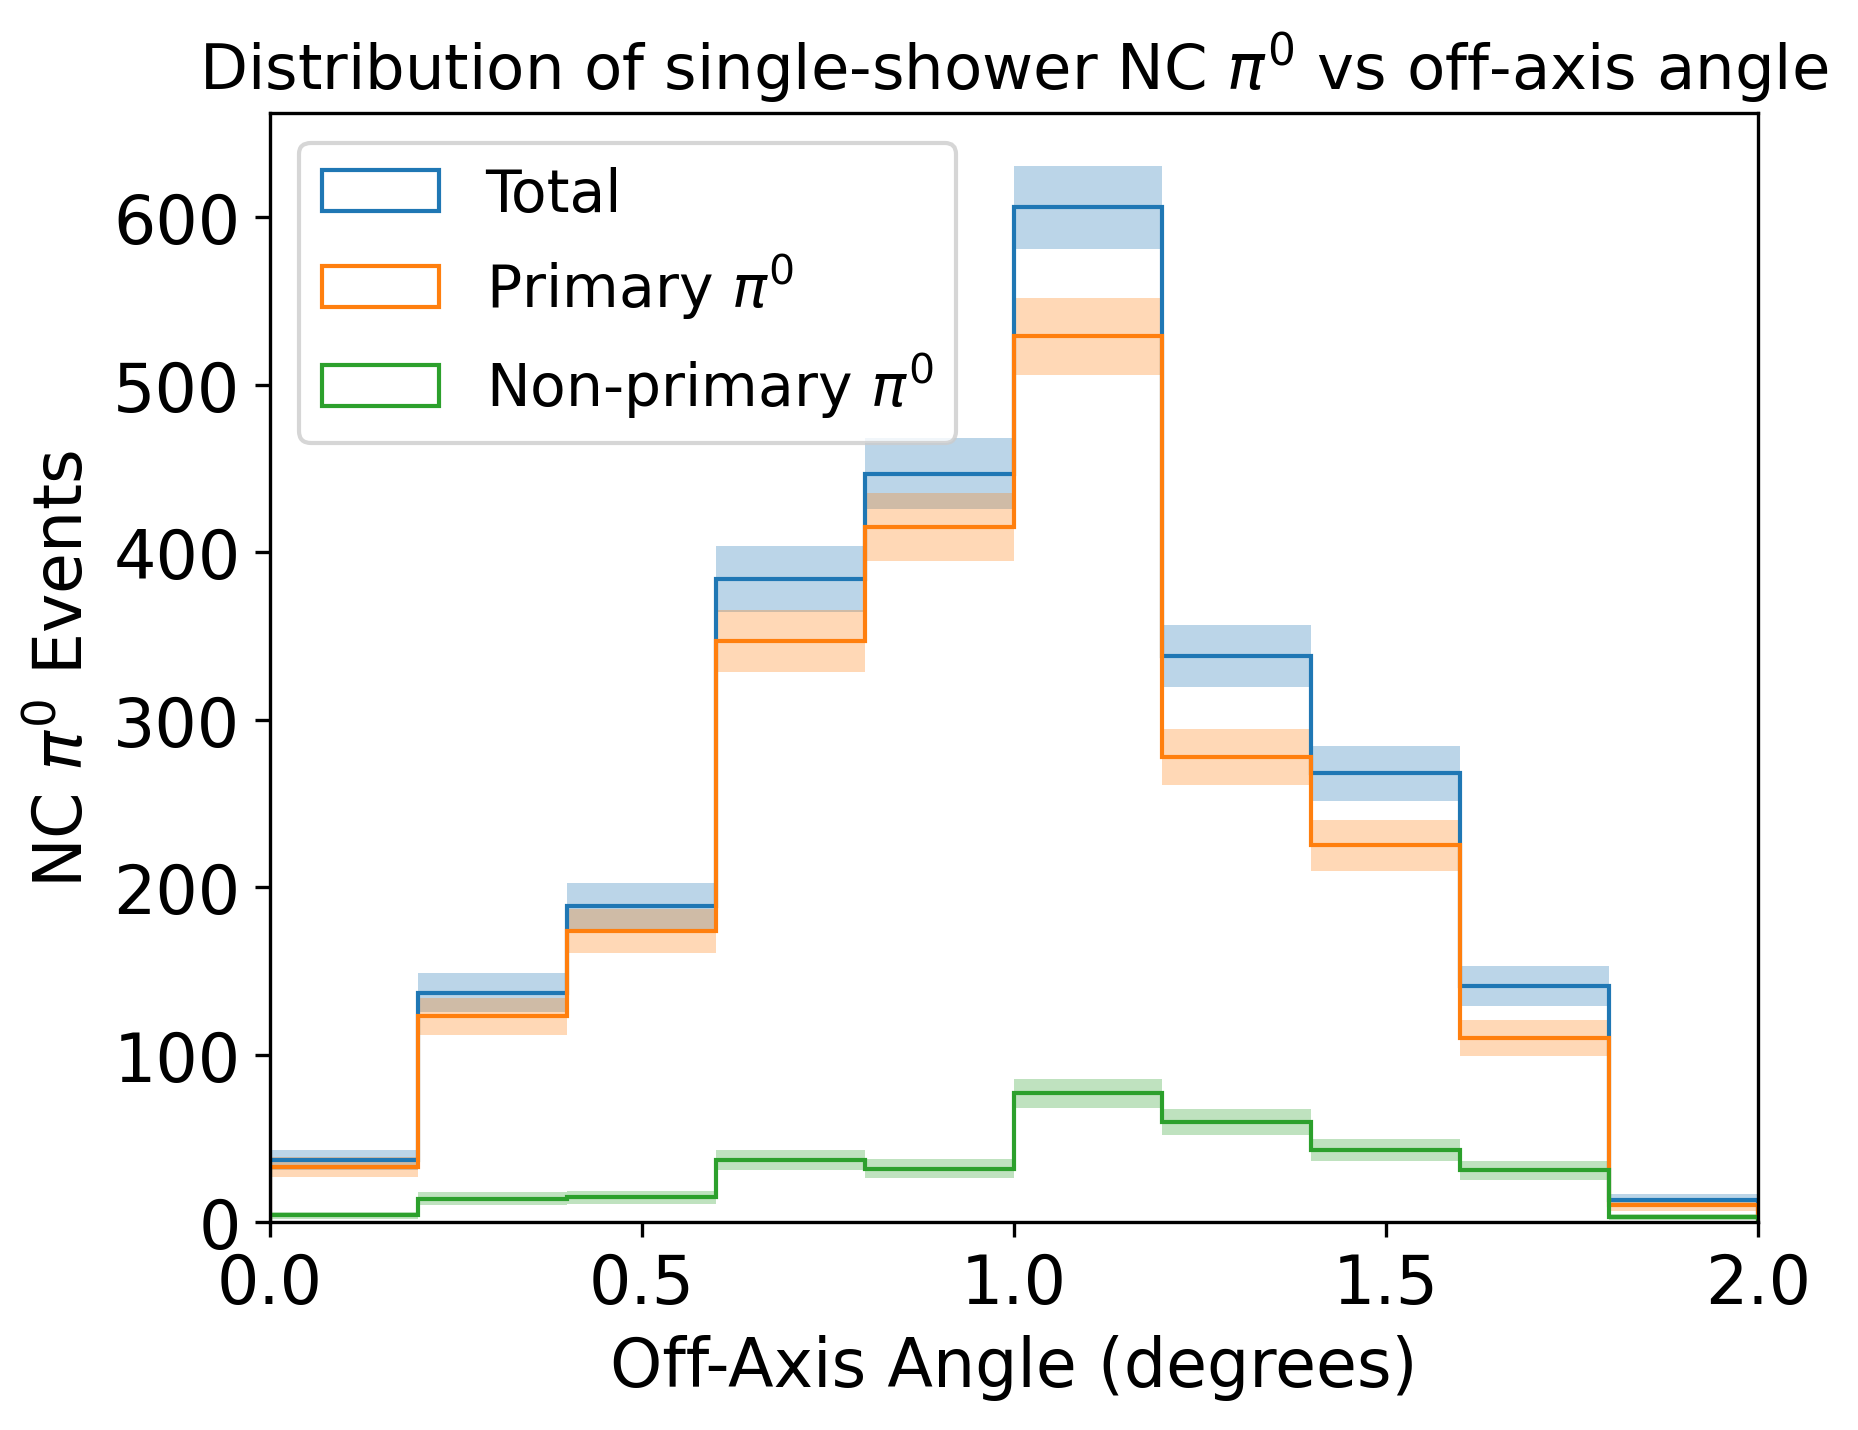

In [42]:
pi0AnglesP = np.array([])
pi0AnglesNP = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    for k in range(len(row['shower_pi0_dex'])):
        if row['shower_pi0_dex'][k] == 0:
            pi0AnglesP = np.append(pi0AnglesP, row['pi0_angle'][k])
        else:
            pi0AnglesNP = np.append(pi0AnglesNP, row['pi0_angle'][k])
assert len(pi0Angles) == len(pi0AnglesP) + len(pi0AnglesNP)

plt.figure(dpi=300)
counts, bins, _ = plt.hist(pi0Angles, bins=nbins, histtype='step')
cP, bP, _ = plt.hist(pi0AnglesP, bins=bins, histtype='step')
cNP, bNP, _ = plt.hist(pi0AnglesNP, bins=bins, histtype='step')
wide = np.diff(bins)
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts)
errP = np.sqrt(cP)
errNP = np.sqrt(cNP)
plt.bar(bin_centers, 2*errors, width=wide, bottom=counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=counts, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=wide, bottom=cP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=cP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=wide, bottom=cNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=cNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.title(r'Distribution of single-shower NC $\pi^0$ vs off-axis angle', fontsize=15)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events')
plt.ylim(*ylimit)
plt.xlim(0,2)
plt.legend(prop={'size':14})
plt.show()

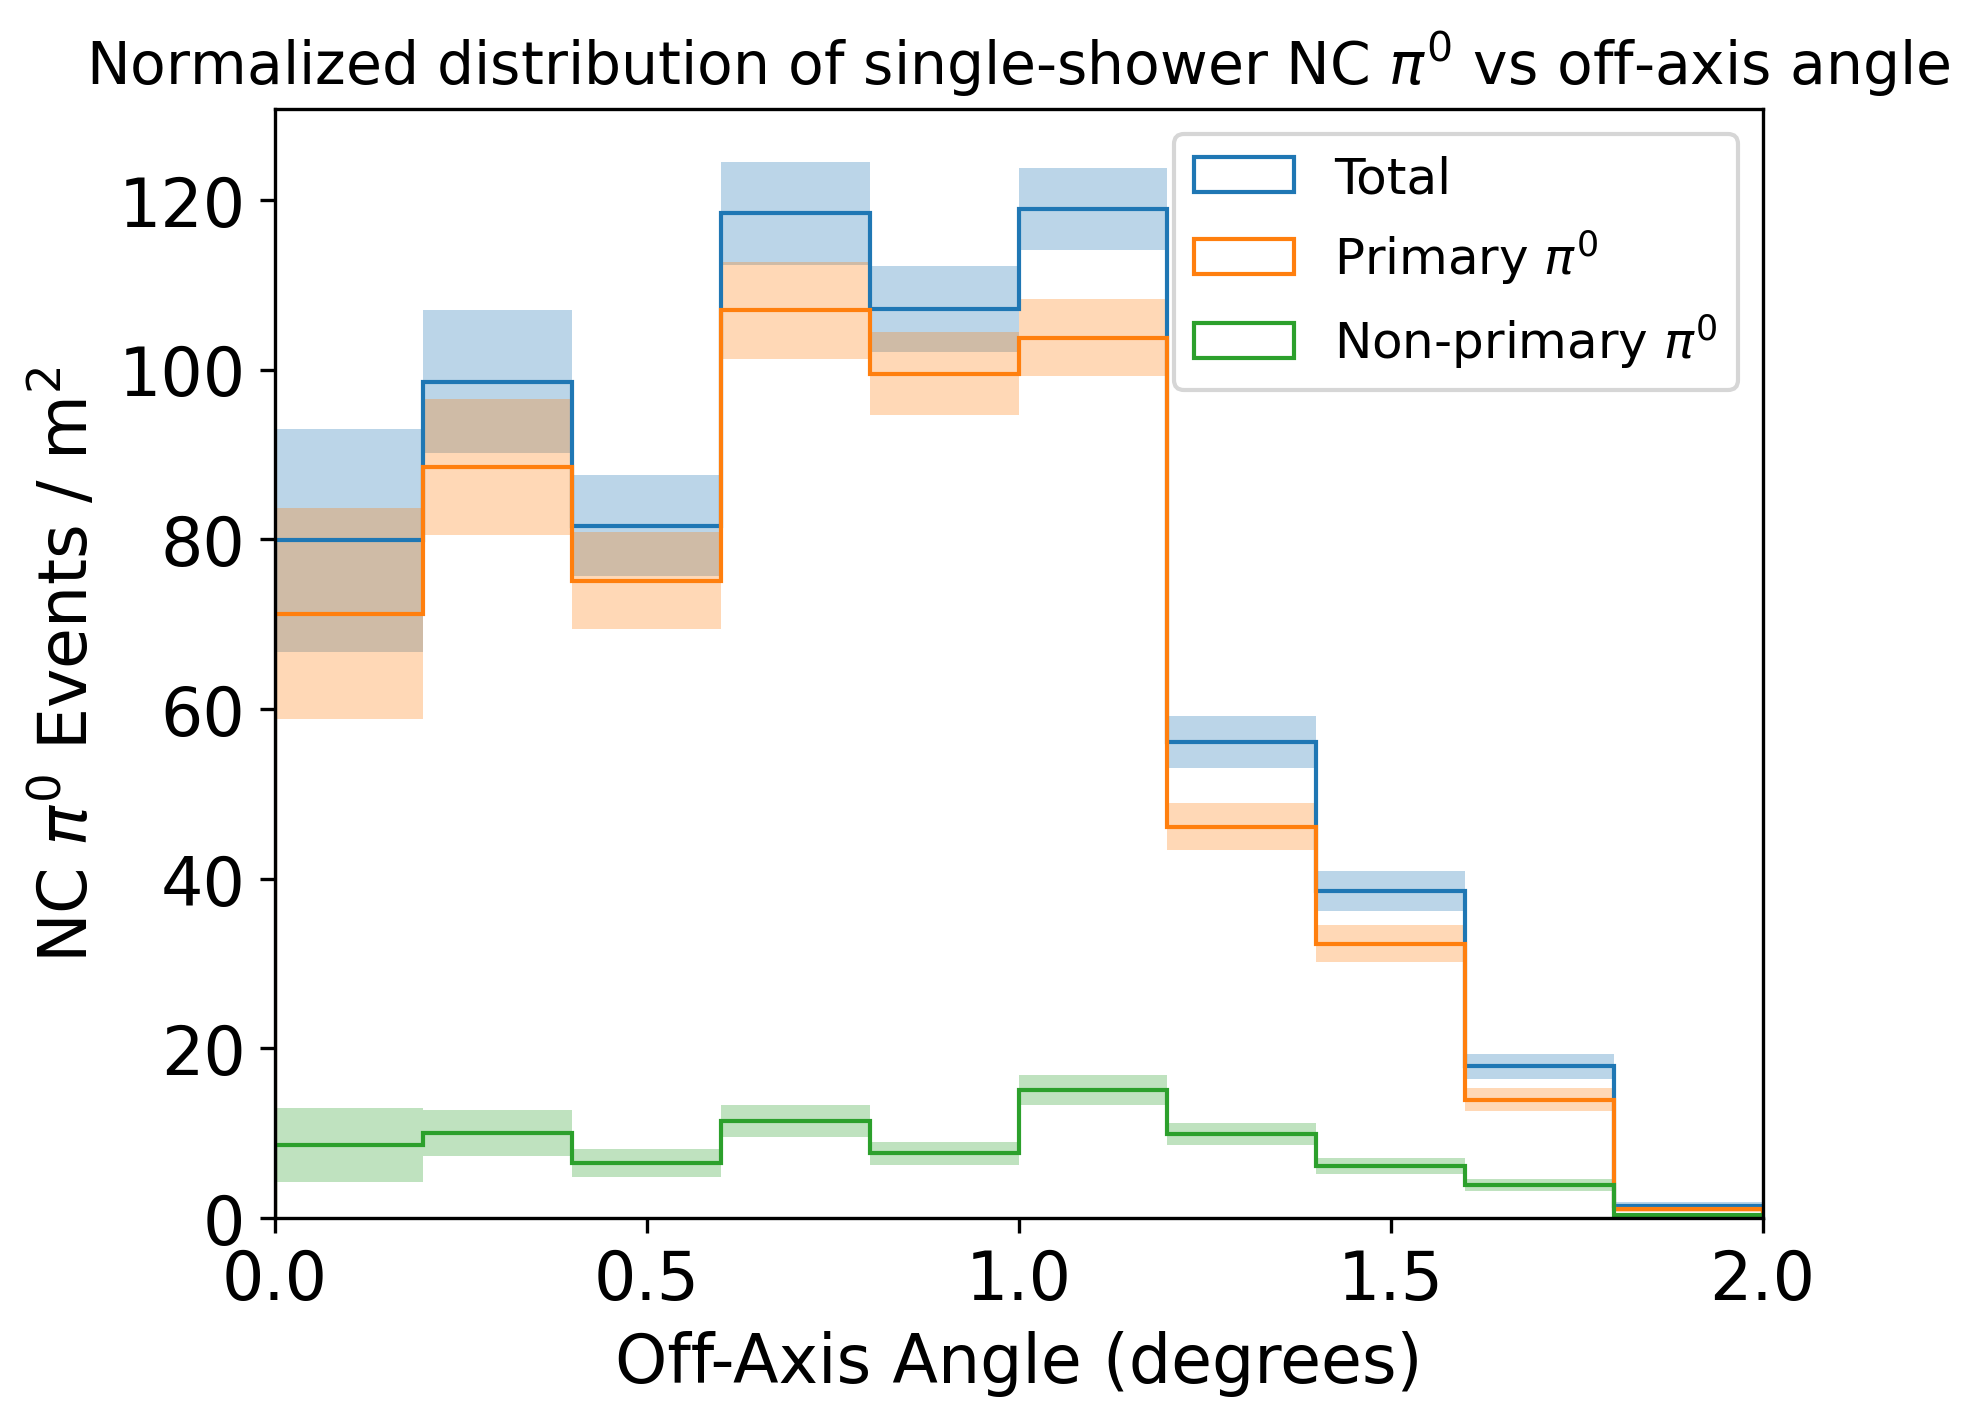

In [43]:
pi0_angles_normP = np.array([])
pi0_angles_normNP = np.array([])
for idx, row in wc_df[~CC_mask & single_shower].iterrows():
    for k in range(len(row['shower_pi0_dex'])):
        if row['shower_pi0_dex'][k] == 0:
            pi0_angles_normP = np.append(pi0_angles_normP, row['pi0_angle'][k])
        else:
            pi0_angles_normNP = np.append(pi0_angles_normNP, row['pi0_angle'][k])
assert len(pi0_angles_norm) == len(pi0_angles_normP) + len(pi0_angles_normNP)

plt.figure(dpi=300)
counts, bins, _ = plt.hist(pi0_angles_norm, bins=nbins, histtype='step')
cP, bP, _ = plt.hist(pi0_angles_normP, bins=bins, histtype='step')
cNP, bNP, _ = plt.hist(pi0_angles_normNP, bins=bins, histtype='step')
wide = np.diff(bins)
bin_widths = np.diff(np.pi*((110*np.tan(bins*np.pi/180))**2))
norm_counts = counts / bin_widths  # normalize by bin width
ncP = cP / bin_widths
ncNP = cNP / bin_widths
plt.clf()  # clear the previous plot
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(counts) / bin_widths
errP = np.sqrt(cP) / bin_widths
errNP = np.sqrt(cNP) / bin_widths
plt.bar(bin_centers, 2*errors, width=wide, bottom=norm_counts-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=norm_counts, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=wide, bottom=ncP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=ncP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=wide, bottom=ncNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=ncNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.title(r'Normalized distribution of single-shower NC $\pi^0$ vs off-axis angle', fontsize = 14)
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel(r'NC $\pi^0$ Events / m$^2$')
plt.ylim(*ylimit)
plt.xlim(0,2)
plt.legend(prop={'size':12})
plt.show()

11450


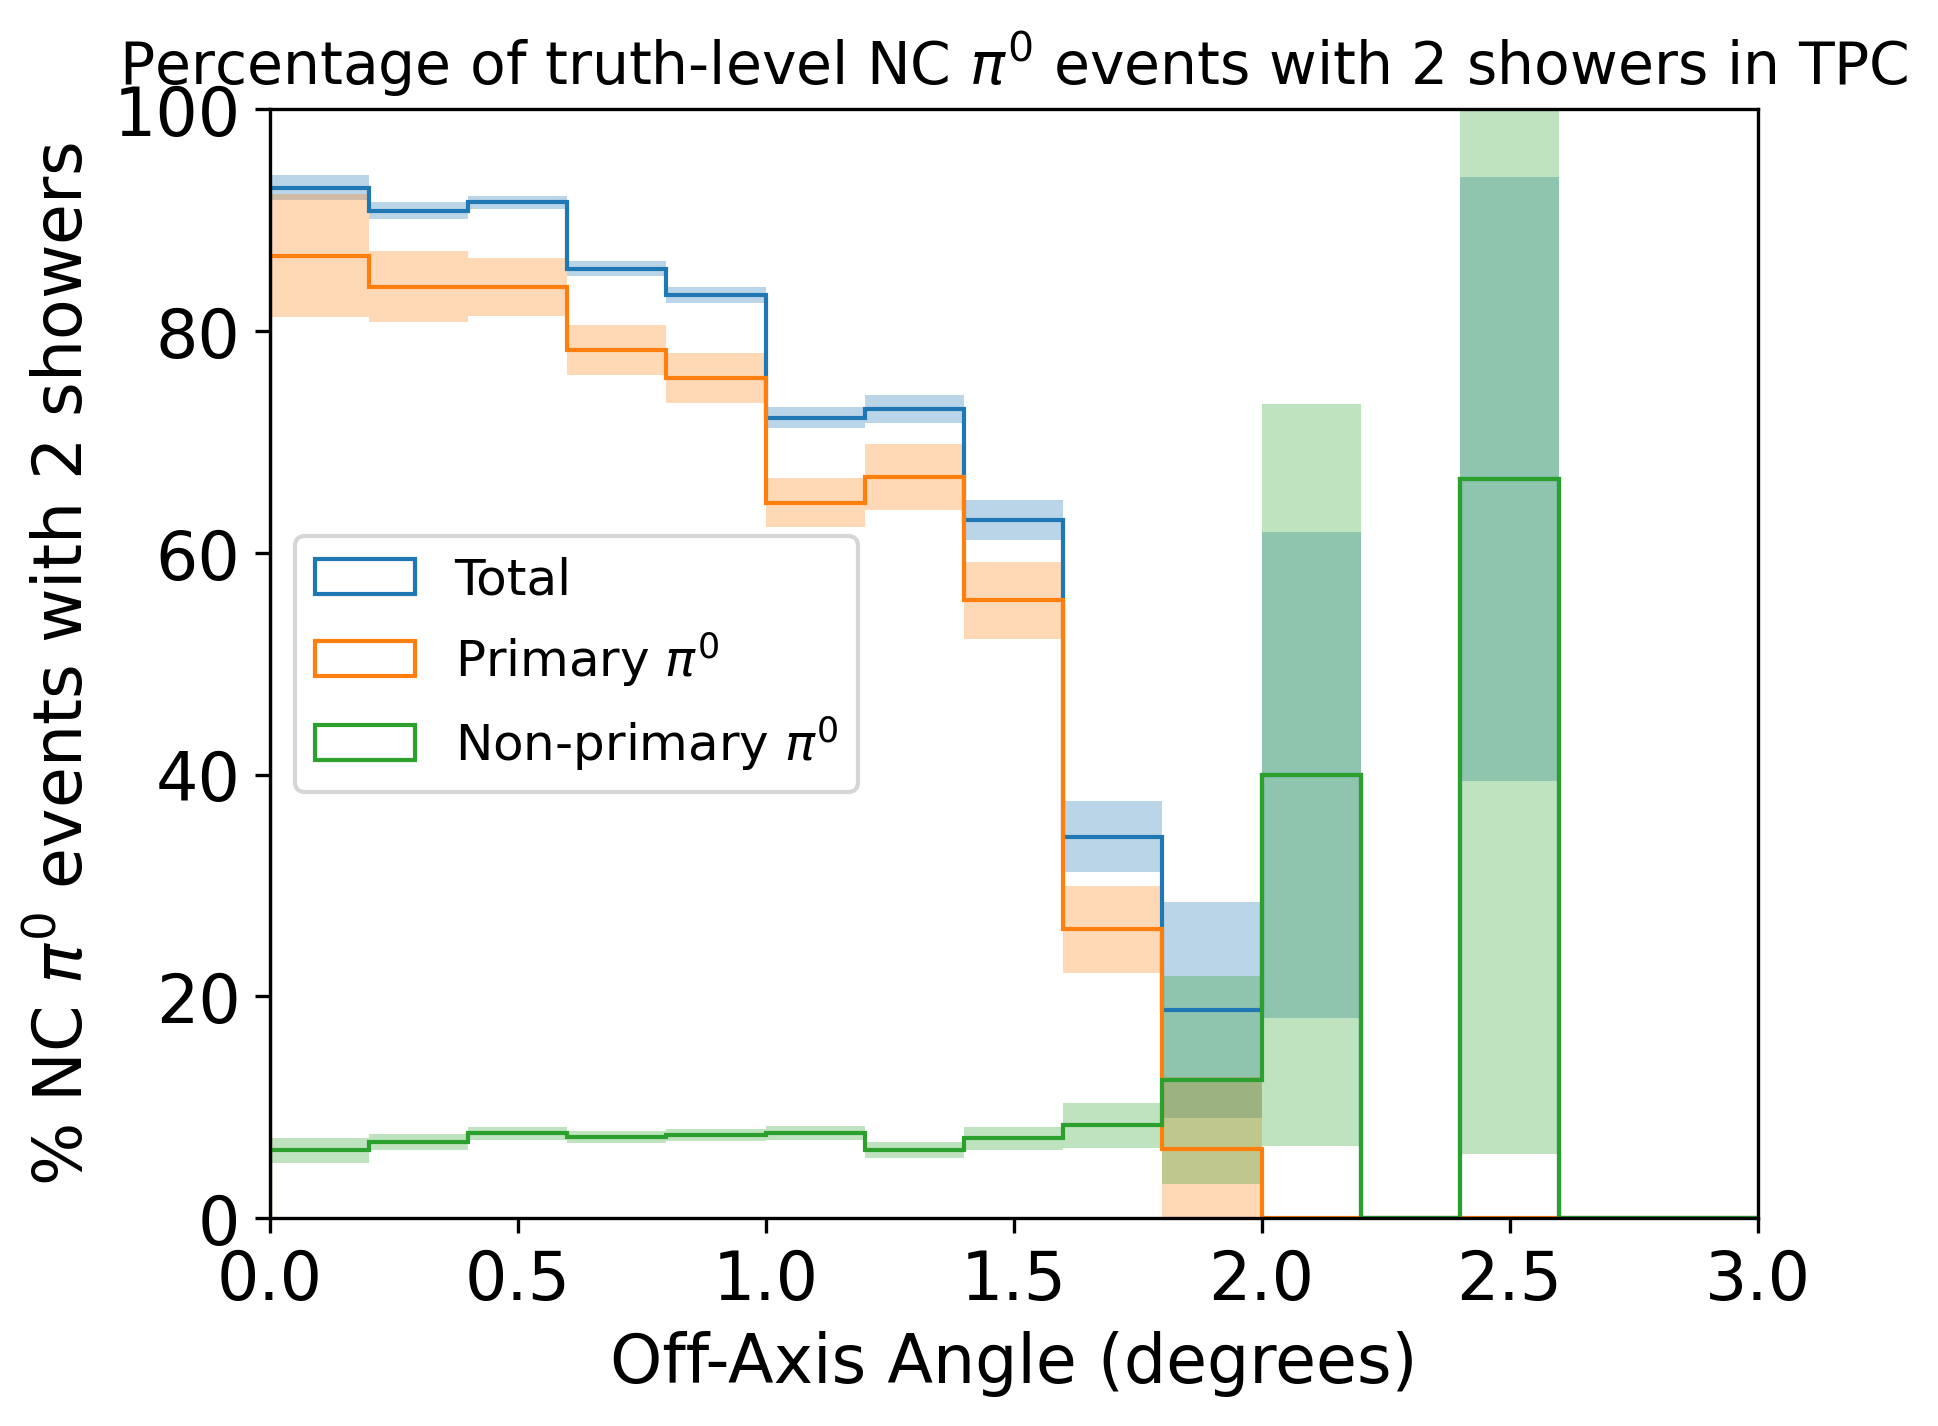

In [44]:
# make a plot of % of NCpi0 events which have 2 shower in TPC as function of NCpi0 vertex and off axis angle
pi0_angles_2 = np.array([])
pi0_angles_2P = np.array([])
pi0_angles_2NP = np.array([])
for idx, row in wc_df[~CC_mask].iterrows():
    if row['N_showers'] == 2:
        pi0_angles_2 = np.append(pi0_angles_2, row['pi0_angle'])
        for k in range(len(row['shower_pi0_dex'])):
            if row['shower_pi0_dex'][k] == 0:
                pi0_angles_2P = np.append(pi0_angles_2P, row['pi0_angle'][k])
            else:
                pi0_angles_2NP = np.append(pi0_angles_2NP, row['pi0_angle'][k])
print(len(pi0_angles_2))

# Calculate histogram for pi0_angles_NC and pi0Angles with the same bins
hist_2, _ = np.histogram(pi0_angles_2, bins=nbins)
hist_2P, _ = np.histogram(pi0_angles_2P, bins=nbins)
hist_2NP, _ = np.histogram(pi0_angles_2NP, bins=nbins)
hist_nc, _ = np.histogram(pi0Angles, bins=nbins)

# Calculate the fraction for each bin
fraction = 100*hist_2/(hist_nc + hist_2 + 1e-10)
fractionP = 100*hist_2P/(hist_nc + hist_2 + 1e-10)
fractionNP = 100*hist_2NP/(hist_nc + hist_2 + 1e-10)
errors = 100*np.sqrt(np.square(hist_nc*np.sqrt(hist_2)) +
                     np.square(hist_2*np.sqrt(hist_nc)))/np.square(hist_nc+hist_2+1e-10)
errP = 100*np.sqrt(np.square(np.sqrt(hist_2P)/(hist_2+hist_nc+1e-10)) + 
                   np.square(hist_2P*np.sqrt(hist_2)/np.square(hist_2+hist_nc+1e-10)) + 
                   np.square(hist_2P*np.sqrt(hist_nc)/np.square(hist_2+hist_nc+1e-10)))
errNP = 100*np.sqrt(np.square(np.sqrt(hist_2NP)/(hist_2+hist_nc+1e-10)) + 
                   np.square(hist_2NP*np.sqrt(hist_2)/np.square(hist_2+hist_nc+1e-10)) + 
                   np.square(hist_2NP*np.sqrt(hist_nc)/np.square(hist_2+hist_nc+1e-10)))

# Plot the histogram
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.figure(dpi=300)
plt.bar(bin_centers, 2*errors, width=np.diff(bins), bottom=fraction-errors, color=colorTot, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=fraction, histtype='step', color=colorTot, label='Total')
plt.bar(bin_centers, 2*errP, width=np.diff(bins), bottom=fractionP-errP, color=colorP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=fractionP, histtype='step', color=colorP, label='Primary $\pi^0$')
plt.bar(bin_centers, 2*errNP, width=np.diff(bins), bottom=fractionNP-errNP, color=colorNP, alpha=erAlpha, align='center', edgecolor='none')
plt.hist(bins[:-1], bins=bins, weights=fractionNP, histtype='step', color=colorNP, label='Non-primary $\pi^0$')
plt.xlabel('Off-Axis Angle (degrees)')
plt.ylabel('% NC $\pi^0$ events with 2 showers')
plt.title('Percentage of truth-level NC $\pi^0$ events with 2 showers in TPC', fontsize=14)
plt.ylim(0, 100)
plt.xlim(0,3)
plt.legend(prop={'size':12})
plt.show()

In [45]:
# projection of the angles effect (front face vs back face of tpc)
# check pi0s normalization scaled to POT
# explore why there are 2 peaks in single-shower off-axis angle distribution (check distance to tpc for shower head)
# pi0 vertex off-angle, normed to in TPC for pi0s inside the TPC that have 1 shower (to represent when we know the vertex)
#       Actually instead of in TPC, take (in TPC and proton with KE >35 MeV)
# normalized event rate/m^2  for 2 showers from pi0 in TPC for pi0 in TPC with OFA calculated from pi0 vertex